# Imports

In [1]:
import subprocess

In [2]:
import altair as alt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from tqdm import tqdm

In [3]:
from utils import CHAR_LOOKUP, flatten_columns, get_datadir

In [4]:
# Create new `pandas` methods which use `tqdm` progress
# (can use tqdm_gui, optional kwargs, etc.)
tqdm.pandas()

In [5]:
alt.data_transformers.enable("data_server")
alt.renderers.enable("altair_saver", fmts=["png"], embed_options={"scaleFactor": "4"})

RendererRegistry.enable('altair_saver')

In [6]:
# allow pandas to show more data
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 1000)

# Select year and load file

In [7]:
year: str = "2005-2006"

In [8]:
# Parameters
year = "2003-2004"


In [9]:
datadir = get_datadir(year)

In [10]:
xptfile = datadir / f"paxraw_{CHAR_LOOKUP[year].lower()}.xpt"
zipfilename = f"PAXRAW_{CHAR_LOOKUP[year].upper()}.ZIP"
zipfile = datadir / zipfilename
if not xptfile.exists():
    print("no extracted xpt file, looking for the zip")
    if not zipfile.exists():
        print("no zip exists, downloading it")
        subprocess.run(
            [
                "wget",
                "-O",
                zipfile,
                f"https://wwwn.cdc.gov/Nchs/Nhanes/{year}/{zipfilename}",
                "--no-use-server-timestamps",
            ]
        )
    print("extracting")
    subprocess.run(["unzip", "-o", zipfile, "-d", datadir])

In [11]:
paxraw = pd.read_sas(xptfile)

In [12]:
paxraw.shape

(72250027, 8)

In [13]:
paxraw.head()

,SEQN,PAXSTAT,PAXCAL,PAXDAY,PAXN,PAXHOUR,PAXMINUT,PAXINTEN
0,21005.0,1.0,1.0,1.0,1.0,5.397605e-79,5.397605e-79,5.397605e-79
1,21005.0,1.0,1.0,1.0,2.0,5.397605e-79,1.000000e+00,5.397605e-79
2,21005.0,1.0,1.0,1.0,3.0,5.397605e-79,2.000000e+00,5.397605e-79
3,21005.0,1.0,1.0,1.0,4.0,5.397605e-79,3.000000e+00,5.397605e-79
4,21005.0,1.0,1.0,1.0,5.0,5.397605e-79,4.000000e+00,5.397605e-79


## Fix datatypes

In [14]:
paxraw.dtypes

SEQN        float64
PAXSTAT     float64
PAXCAL      float64
PAXDAY      float64
PAXN        float64
PAXHOUR     float64
PAXMINUT    float64
PAXINTEN    float64
dtype: object

In [15]:
for col in paxraw.columns:
    print(f"casting {col=} to int")
    try:
        paxraw.loc[:, col] = paxraw.loc[:, col].astype(int)
    except pd.errors.IntCastingNaNError:
        print(f"{col=} has {paxraw.loc[:, col].isna().sum()} NA values, setting to 0")
        paxraw.loc[:, col] = paxraw.loc[:, col].replace(np.nan, 0).astype(int)

casting col='SEQN' to int


/var/folders/92/jlcv07t503q05dghb407p5bd4_6dlc/T/ipykernel_77784/2208879285.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  paxraw.loc[:, col] = paxraw.loc[:, col].astype(int)


casting col='PAXSTAT' to int


casting col='PAXCAL' to int


casting col='PAXDAY' to int


casting col='PAXN' to int


casting col='PAXHOUR' to int


casting col='PAXMINUT' to int


casting col='PAXINTEN' to int


### Don't add a datetime column, takes too long

```
paxraw["datetime"] = paxraw.progress_apply(
    lambda x: datetime.datetime(2006, 1, 1) + datetime.timedelta(
        days=int(x.PAXDAY - 1),
        hours=int(x.PAXHOUR),
        minutes=int(x.PAXMINUT)
    ),
    axis=1,
)
```

In [16]:
paxraw.dtypes

SEQN        int64
PAXSTAT     int64
PAXCAL      int64
PAXDAY      int64
PAXN        int64
PAXHOUR     int64
PAXMINUT    int64
PAXINTEN    int64
dtype: object

In [17]:
paxraw.head()

,SEQN,PAXSTAT,PAXCAL,PAXDAY,PAXN,PAXHOUR,PAXMINUT,PAXINTEN
0,21005,1,1,1,1,0,0,0
1,21005,1,1,1,2,0,1,0
2,21005,1,1,1,3,0,2,0
3,21005,1,1,1,4,0,3,0
4,21005,1,1,1,5,0,4,0


## Save parquet

In [18]:
parquetfile = datadir / f"paxraw_{CHAR_LOOKUP[year].lower()}.parquet"
parquetfile

PosixPath('~/projects/2022/07-nhanes-analysis/data/raw/2003-2004/paxraw_c.parquet')

In [19]:
paxraw.to_parquet(parquetfile)
# paxraw = pd.read_parquet(parquetfile)

# Define intensity level cuts and METs

In [20]:
# cuts defined in literature and in [common software](https://github.com/vandomed/nhanesaccel/blob/7ebd7a0cd6e2f169e6f81a66c8c99b1746eacb51/R/process_nhanes.R#L267)
int_cuts = [100, 760, 2020, 5999]

In [21]:
# add end ranges for interpolation
int_cuts_endranges = [paxraw.PAXINTEN.min()] + int_cuts + [paxraw.PAXINTEN.max() + 1]
int_cuts_endranges

[0, 100, 760, 2020, 5999, 32768]

In [22]:
len(int_cuts_endranges) - 1

5

In [23]:
# MET values corresponding to each cut point
METs = [1, 1, 2, 3.5, 6, 10]
labels = ["Sedentary", "Low", "Light", "Moderate", "Vigorous"]

In [24]:
# linearly interpolate MET values
METs_full = np.interp(
    np.arange(int_cuts_endranges[0], int_cuts_endranges[-1]), int_cuts_endranges, METs
)
METs_lookup = pd.DataFrame(
    {
        "MET": METs_full,
        "PAXINTEN": np.arange(int_cuts_endranges[0], int_cuts_endranges[-1]),
    }
)

## Join METs

In [25]:
paxraw = paxraw.merge(METs_lookup, how="left", on="PAXINTEN")

## Save parquet

In [26]:
parquetfile = datadir / f"paxraw_{CHAR_LOOKUP[year].lower()}_met.parquet"
parquetfile

PosixPath('~/projects/2022/07-nhanes-analysis/data/raw/2003-2004/paxraw_c_met.parquet')

In [27]:
paxraw.to_parquet(parquetfile)

# `worn` classification

[R code here](https://github.com/vandomed/nhanesaccel/blob/7ebd7a0cd6e2f169e6f81a66c8c99b1746eacb51/misc/process_nhanes_app_10_2_18.R)

## Run a sample of data through

In [28]:
paxraw_sample = paxraw.loc[paxraw.SEQN == paxraw.SEQN.values[0], :].copy()
paxraw_sample.shape

(10080, 9)

In [29]:
min_worn_hours_threshold: int = 10
max_nonzero_count_per_unworn_hour: int = 2
max_of_nonzero_in_unworn_hour: int = 100
MINUTES_PER_HOUR = 60

In [30]:
paxraw_sample.columns

Index(['SEQN', 'PAXSTAT', 'PAXCAL', 'PAXDAY', 'PAXN', 'PAXHOUR', 'PAXMINUT',
       'PAXINTEN', 'MET'],
      dtype='object')

In [31]:
# set the indicator to True to start
worn = np.ones(paxraw_sample.shape[0])

In [32]:
worn.shape

(10080,)

paxraw = paxraw_sample

In [33]:
paxinten = paxraw_sample.PAXINTEN.values

In [34]:
paxinten.shape[0]

10080

## Time a simple algorithm using numpy arrays

In [35]:
# take the first hour
# assert d.iloc[:MINUTES_PER_HOUR, :].shape[0] == MINUTES_PER_HOUR
if ((paxinten[:MINUTES_PER_HOUR] > 0).sum() <= max_nonzero_count_per_unworn_hour) and (
    (paxinten[:MINUTES_PER_HOUR] < max_of_nonzero_in_unworn_hour).sum() == MINUTES_PER_HOUR
):
    worn[:MINUTES_PER_HOUR] = 0

In [36]:
for i in range(MINUTES_PER_HOUR + 1, worn.shape[0]):
    # assert paxraw_sample.iloc[(i-60):i, :].shape[0] == MINUTES_PER_HOUR
    if ((paxinten[(i - MINUTES_PER_HOUR) : i] > 0).sum() <= max_nonzero_count_per_unworn_hour) and (
        (paxinten[(i - MINUTES_PER_HOUR) : i] < max_of_nonzero_in_unworn_hour).sum()
        == MINUTES_PER_HOUR
    ):
        worn[(i - MINUTES_PER_HOUR) : i] = 0

### Write that as a function (in `util.py`)

In [37]:
from utils import worn_indicator, worn_indicator_fast  # noqa: E402

In [38]:
%%timeit
worn_indicator(paxraw_sample.PAXINTEN.values)

67.9 ms ± 3.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Run it once to compile it

In [39]:
worn_indicator_fast(paxraw_sample.PAXINTEN.values)

array([1., 1., 1., ..., 0., 0., 0.])

In [40]:
%%timeit
worn_indicator_fast(paxraw_sample.PAXINTEN.values)

2.31 ms ± 46.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Test an algorithm using pandas

### Process out active minutes akin to Fishman (2016)

1. Compute worn/nonworn indicator on each minute, defined as intervals at least 60 minutes of count = 0, with up to two count < 100.
2. Sum worn time per day.
3. Discard days with wear time < 10h.
4. Sum up total count per day.
4. Measure average total count per day on valid days, per individual.

In [41]:
paxraw_sample.head()

,SEQN,PAXSTAT,PAXCAL,PAXDAY,PAXN,PAXHOUR,PAXMINUT,PAXINTEN,MET
0,21005,1,1,1,1,0,0,0,1.0
1,21005,1,1,1,2,0,1,0,1.0
2,21005,1,1,1,3,0,2,0,1.0
3,21005,1,1,1,4,0,3,0,1.0
4,21005,1,1,1,5,0,4,0,1.0


In [42]:
paxraw_sample.head()

,SEQN,PAXSTAT,PAXCAL,PAXDAY,PAXN,PAXHOUR,PAXMINUT,PAXINTEN,MET
0,21005,1,1,1,1,0,0,0,1.0
1,21005,1,1,1,2,0,1,0,1.0
2,21005,1,1,1,3,0,2,0,1.0
3,21005,1,1,1,4,0,3,0,1.0
4,21005,1,1,1,5,0,4,0,1.0


In [43]:
# set the indicator to True to start
paxraw_sample.loc[:, "worn"] = True

In [44]:
paxraw_sample.columns

Index(['SEQN', 'PAXSTAT', 'PAXCAL', 'PAXDAY', 'PAXN', 'PAXHOUR', 'PAXMINUT',
       'PAXINTEN', 'MET', 'worn'],
      dtype='object')

In [45]:
PAXINTEN_col = np.arange(paxraw_sample.shape[1])[paxraw_sample.columns == "PAXINTEN"][0]

In [46]:
worn_col = np.arange(paxraw_sample.shape[1])[paxraw_sample.columns == "worn"][0]

In [47]:
# take the first 60 minutes
assert paxraw_sample.iloc[:60, :].shape[0] == 60
if (paxraw_sample.iloc[:60, PAXINTEN_col] >= 100).sum() <= 2:
    paxraw_sample.iloc[:60, worn_col] = False

In [48]:
paxraw_sample.iloc[paxraw_sample.shape[0] - 60 : paxraw_sample.shape[0], :].shape

(60, 10)

In [49]:
for i in range(61, paxraw_sample.shape[0]):
    assert paxraw_sample.iloc[(i - 60) : i, :].shape[0] == 60
    if (paxraw_sample.iloc[(i - 60) : i, PAXINTEN_col] >= 100).sum() <= 2:
        paxraw_sample.iloc[(i - 60) : i, worn_col] = False

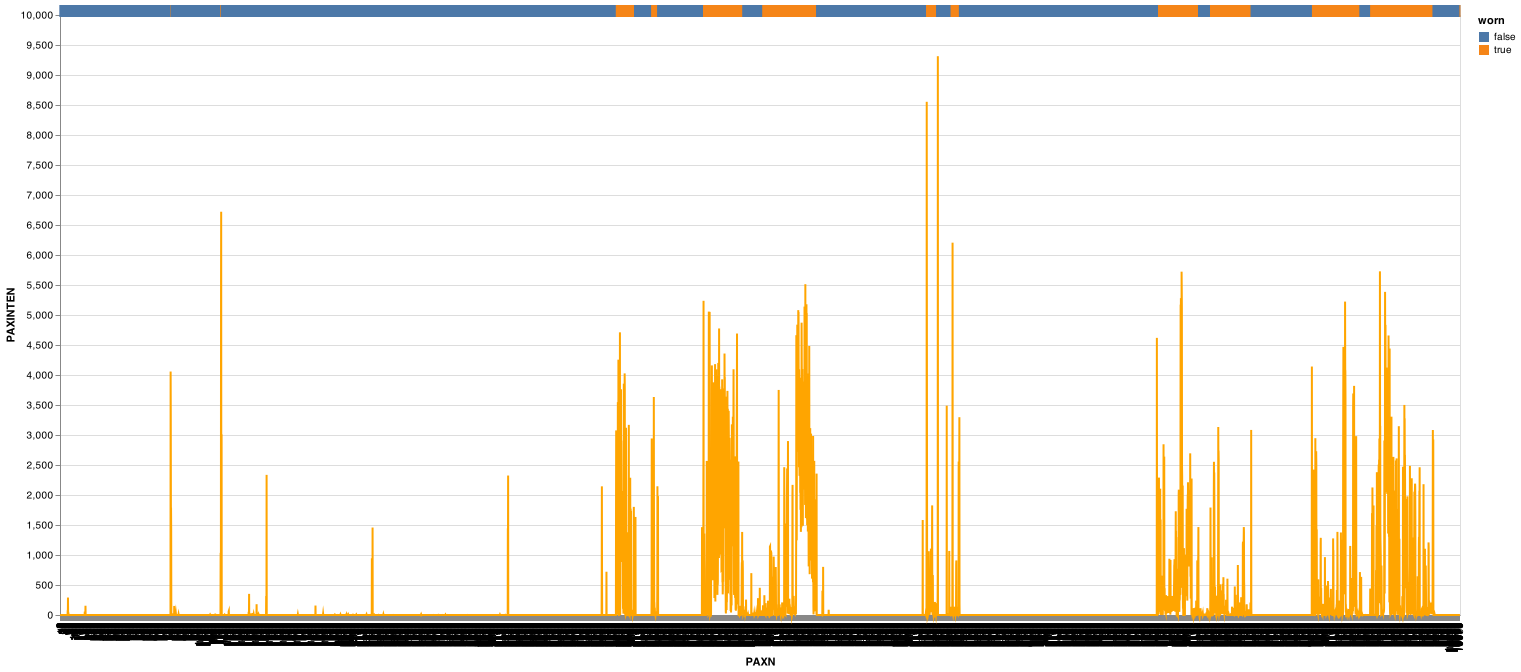

In [50]:
worn_chart = (
    alt.Chart(paxraw_sample)
    .mark_bar(width=1)
    .encode(x="PAXN:O", y=alt.value(-10), y2=alt.value(2), color="worn")
)
inten_chart = alt.Chart(paxraw_sample).mark_line(color="orange").encode(x="PAXN:O", y="PAXINTEN")
if "PAXSTEP" in paxraw_sample.columns:
    step_chart = alt.Chart(paxraw_sample).mark_line().encode(x="PAXN:O", y="PAXSTEP")
    chart = worn_chart + inten_chart + step_chart
else:
    chart = worn_chart + inten_chart
chart.properties(width=1400, height=600)

In [51]:
# set the indicator to True to start
paxraw_sample.loc[:, "worn"] = True
# take the first 60 minutes
assert paxraw_sample.iloc[:60, :].shape[0] == 60
# only 2 allowed > 0, and all 60 are less than 100
if ((paxraw_sample.iloc[:60, PAXINTEN_col] > 0).sum() <= 2) and (
    (paxraw_sample.iloc[:60, PAXINTEN_col] < 100).sum() == 60
):
    paxraw_sample.iloc[:60, worn_col] = False

In [52]:
for i in range(61, paxraw_sample.shape[0]):
    assert paxraw_sample.iloc[(i - 60) : i, :].shape[0] == 60
    if ((paxraw_sample.iloc[(i - 60) : i, PAXINTEN_col] > 0).sum() <= 2) and (
        (paxraw_sample.iloc[(i - 60) : i, PAXINTEN_col] < 100).sum() == 60
    ):
        paxraw_sample.iloc[(i - 60) : i, worn_col] = False

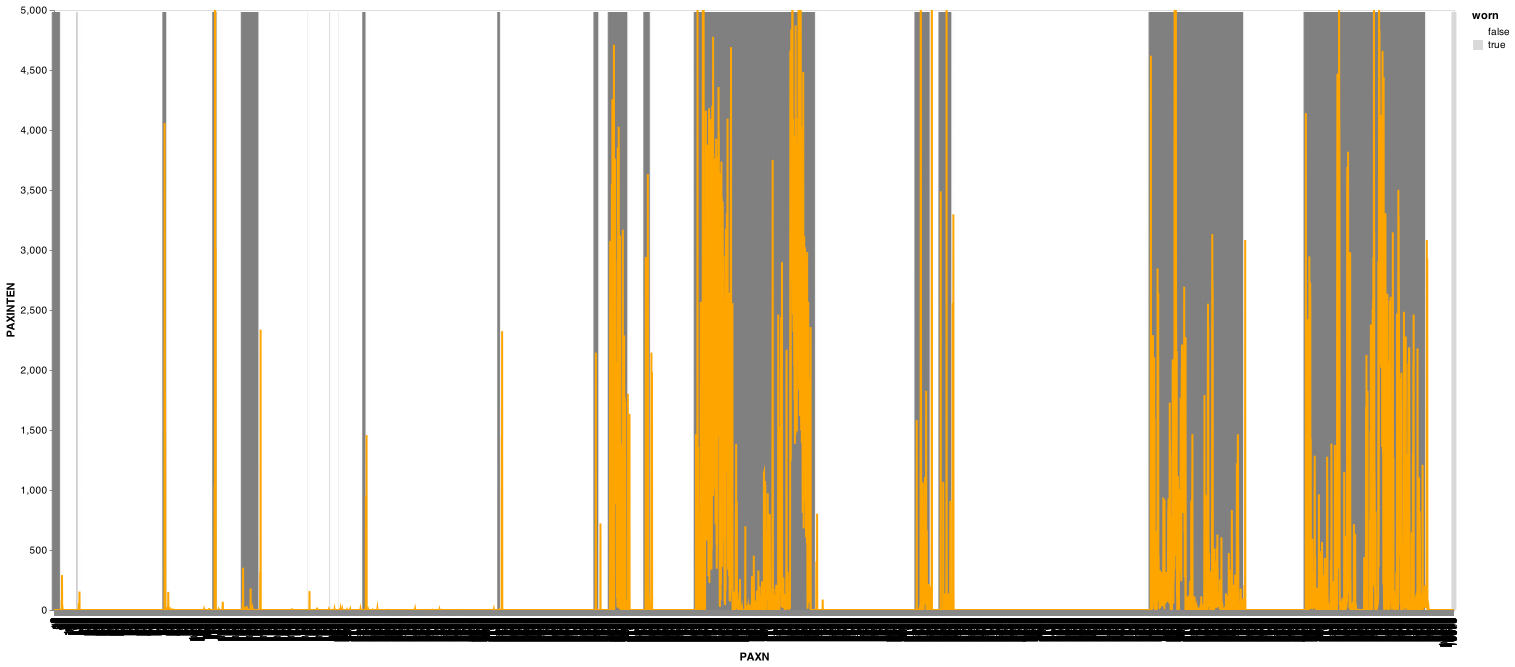

In [53]:
(
    alt.Chart(paxraw_sample)
    .mark_bar(width=5, opacity=0.3)
    .encode(
        x="PAXN:O",
        y=alt.value(600),
        y2=alt.value(2),
        color=alt.Color("worn", scale=alt.Scale(range=["white", "grey"])),
    )
    + alt.Chart(paxraw_sample)
    .mark_line(color="orange", clip=True)
    .encode(x="PAXN:O", y=alt.Y("PAXINTEN", scale=alt.Scale(domain=[0, 5000])))
).properties(width=1400, height=600)

In [54]:
# set the indicator to False to start
paxraw_sample.loc[:, "worn"] = False
# take the first 60 minutes
assert paxraw_sample.iloc[:60, :].shape[0] == 60
# only 2 allowed > 0, and all 60 are less than 100
if ((paxraw_sample.iloc[:60, PAXINTEN_col] > 0).sum() > 2) or (
    (paxraw_sample.iloc[:60, PAXINTEN_col] >= 100).sum() > 0
):
    paxraw_sample.iloc[:60, worn_col] = True

In [55]:
for i in range(61, paxraw_sample.shape[0]):
    assert paxraw_sample.iloc[(i - 60) : i, :].shape[0] == 60
    if ((paxraw_sample.iloc[(i - 60) : i, PAXINTEN_col] > 0).sum() > 2) or (
        (paxraw_sample.iloc[(i - 60) : i, PAXINTEN_col] >= 100).sum() > 0
    ):
        paxraw_sample.iloc[(i - worn_col) : i, worn_col] = True

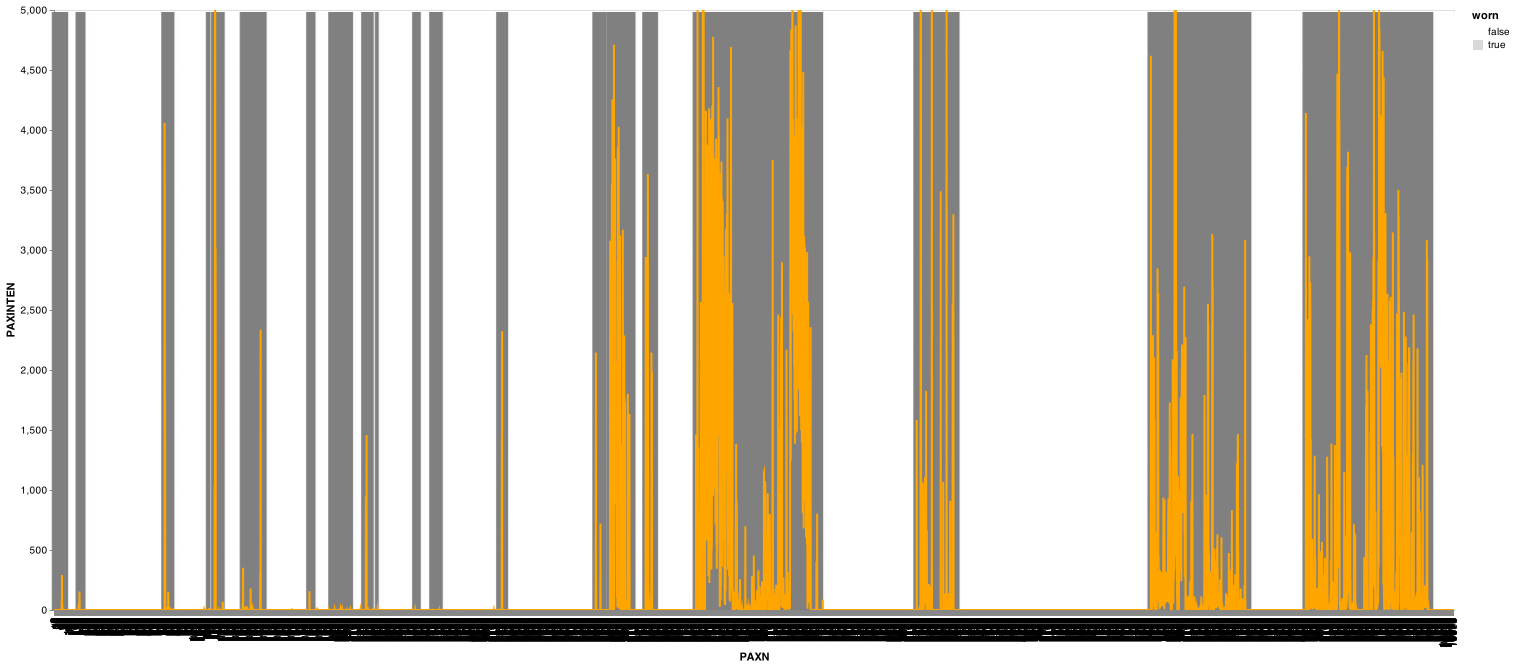

In [56]:
(
    alt.Chart(paxraw_sample)
    .mark_bar(width=5, opacity=0.3)
    .encode(
        x="PAXN:O",
        y=alt.value(600),
        y2=alt.value(2),
        color=alt.Color("worn", scale=alt.Scale(range=["white", "grey"])),
    )
    + alt.Chart(paxraw_sample)
    .mark_line(color="orange", clip=True)
    .encode(x="PAXN:O", y=alt.Y("PAXINTEN", scale=alt.Scale(domain=[0, 5000])))
).properties(width=1400, height=600)

In [57]:
worn_minutes = paxraw_sample.groupby("PAXDAY").agg({"worn": [sum], "PAXINTEN": [sum]})
worn_minutes["valid_day"] = worn_minutes["worn"]["sum"] > min_worn_hours_threshold * 60
# filter to valid days
worn_minutes = worn_minutes.loc[worn_minutes.valid_day, :]
np.mean(worn_minutes["PAXINTEN"]["sum"])

393801.25

In [58]:
from utils import get_person_active_count  # noqa: E402

In [59]:
get_person_active_count(paxraw.loc[paxraw.SEQN == paxraw.SEQN.unique()[0], :])

,worn,PAXINTEN,valid_day
,sum,sum,
PAXDAY,,,
1,202,32695,False
2,76,5380,False
3,243,143783,False
4,873,851618,True
5,203,74453,False
6,681,249123,True
7,876,469084,True


In [60]:
%%timeit
get_person_active_count(paxraw.loc[paxraw.SEQN == paxraw.SEQN.unique()[0], :])

4.64 s ± 252 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Hours:

In [61]:
3.13 * (paxraw["SEQN"].unique().shape[0]) / 60 / 60

6.239133333333333

### Test it on a slightly bigger sample

Make sure the groupby object returned makes sense before waiting 8 hours

In [62]:
person_active_counts = (
    paxraw.loc[paxraw.SEQN.isin(paxraw.SEQN.unique()[:10]), :]
    .groupby("SEQN")
    .progress_apply(get_person_active_count)
)

  0%|                                                                                                                       | 0/10 [00:00<?, ?it/s]

 20%|██████████████████████▏                                                                                        | 2/10 [00:04<00:16,  2.04s/it]

 30%|█████████████████████████████████▎                                                                             | 3/10 [00:08<00:21,  3.08s/it]

 40%|████████████████████████████████████████████▍                                                                  | 4/10 [00:12<00:19,  3.25s/it]

 50%|███████████████████████████████████████████████████████▌                                                       | 5/10 [00:16<00:18,  3.77s/it]

 60%|██████████████████████████████████████████████████████████████████▌                                            | 6/10 [00:20<00:15,  3.77s/it]

 70%|█████████████████████████████████████████████████████████████████████████████▋                                 | 7/10 [00:25<00:11,  3.96s/it]

 80%|████████████████████████████████████████████████████████████████████████████████████████▊                      | 8/10 [00:28<00:07,  3.78s/it]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▉           | 9/10 [00:32<00:03,  3.81s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:36<00:00,  3.80s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.05s/it]

In [63]:
person_active_counts

worn PAXINTEN valid_day
               sum      sum          
SEQN  PAXDAY                         
21005 1        202    32695     False
      2         76     5380     False
      3        243   143783     False
      4        873   851618      True
      5        203    74453     False
      6        681   249123      True
      7        876   469084      True
21006 1        960   217932      True
      2        712    69560      True
      3        597   206583     False
      4        448    99358     False
      5        581   185269     False
      6        615   150717      True
      7        651    30908      True
21007 1        737   438907      True
      2        910   400517      True
      3        869   316556      True
      4        825   386072      True
      5       1098   293143      True
      6       1284   437497      True
      7        658   255734      True
21008 1        583   605287     False
      2         77     8517     False
      3        420    31406     False
      4        802     7618      True
      5        784   444873      True
      6        536   371741     False
      7        780   192324      True
21009 1        953   366414      True
      2        949   507292      True
      3        981   322404      True
      4        949   578837      True
      5        767   388850      True
      6        645   568553      True
      7       1059   133171      True
21010 1        783   409417      True
      2        824   351251      True
      3        774   224345      True
      4        803   197665      True
      5        617   140445      True
      6        875   283398      True
      7        725   398339      True
21012 1       1367   188752      True
      2        735    77106      True
      3        899   132312      True
      4       1440   118490      True
      5        958   178392      True
      6        781   133291      True
      7        995    87491      True
21013 1        640   133624      True
      2        947   347498      True
      3          2     1801     False
      4        847   146767      True
      5        827   150839      True
      6        969   288338      True
      7        533   144262     False
21015 1        611    84317      True
      2        684   103342      True
      3        632    60211      True
      4        882    84964      True
      5       1356   151834      True
      6        639    71376      True
      7        766   161950      True
21016 1        614   222672      True
      2        907   487651      True
      3        837   280816      True
      4       1026   398366      True
      5        889   222057      True
      6          3     3639     False
      7        510    25167     False

In [64]:
# check that we can save and load it
# with the heirarchical indexes
parquetfile = datadir / f"paxraw_{CHAR_LOOKUP[year].lower()}_sample_test_write.parquet"
person_active_counts.to_parquet(parquetfile)
pd.read_parquet(parquetfile).head()

worn PAXINTEN valid_day
              sum      sum          
SEQN  PAXDAY                        
21005 1       202    32695     False
      2        76     5380     False
      3       243   143783     False
      4       873   851618      True
      5       203    74453     False

### Don't apply the numpy-based function to Pandas column, too slow

Because it takes almost 30 minutes.

this would take ~25 minutes
```
paxraw['worn'] = 1

for SEQN in tqdm(pd.unique(paxraw.SEQN.values)):
    paxraw.loc[paxraw.SEQN == SEQN, 'worn'] = worn_indicator(paxraw.loc[paxraw.SEQN == SEQN, 'PAXINTEN'].values)
```

```
parquetfile = datadir / f"paxraw_{CHAR_LOOKUP[year].lower()}_met_worn.parquet"
paxraw.to_parquet(parquetfile)
```

### Skip a fully pandas-based solution entirely, it's very very slow

FWIW, the `rolling` version should take better advantage of Pandas,
but it's still too slow.

```
person_active_counts = (
    paxraw.groupby("SEQN").progress_apply(get_person_active_count).reset_index()
)
```

## Apply ~numpy-based~ numba algorithm to full dataset

~Less than 10 min.~

A few seconds.

In [65]:
from utils import bout_classifier_SEQN_long, worn_indicator_SEQN_long_fast  # noqa: E402

In [66]:
# this should be fast
paxraw["worn"] = worn_indicator_SEQN_long_fast(paxraw.PAXINTEN.values, paxraw.SEQN.values)

### Compare the full numpy and the numpy function applied to pandas array

It's commented out because we're not running the "numpy function applied to pandas array" version now.
They are the same

```
(paxraw['worn'] == worn).sum()
```

```
(paxraw['worn'] != worn).sum()
```

```
(paxraw['worn'] == worn).sum() == worn.shape[0]
```

```
paxraw.loc[(paxraw.worn != worn), :].head()
```

## Save parquet

In [67]:
parquetfile = datadir / f"paxraw_{CHAR_LOOKUP[year].lower()}_met_worn.parquet"
parquetfile

PosixPath('~/projects/2022/07-nhanes-analysis/data/raw/2003-2004/paxraw_c_met_worn.parquet')

In [68]:
paxraw.to_parquet(parquetfile)

# Generate indicators for `bouts` of activity levels

In [69]:
paxraw["vigorous_bout"] = bout_classifier_SEQN_long(
    paxraw.PAXINTEN.values,
    paxraw.SEQN.values,
    paxraw.worn.values,
    np.zeros(paxraw.PAXINTEN.values.shape[0]),
    upper=int_cuts_endranges[5],
    lower=int_cuts_endranges[4],
    tol_upper_soft=0,
    tol_lower_soft=0,
    m=10,
    lower_soft=(int_cuts_endranges[3] + int_cuts_endranges[4]) / 2,
    check_already_classified=False,
)

In [70]:
paxraw["moderate_bout"] = bout_classifier_SEQN_long(
    paxraw.PAXINTEN.values,
    paxraw.SEQN.values,
    paxraw.worn.values,
    paxraw.vigorous_bout.values,
    upper=int_cuts_endranges[4],
    lower=int_cuts_endranges[3],
    tol_upper_soft=10,
    tol_lower_soft=0,
    m=10,
    lower_soft=(int_cuts_endranges[2] + int_cuts_endranges[3]) / 2,
    upper_soft=int_cuts_endranges[5],
    check_already_classified=True,
)

In [71]:
paxraw["light_bout"] = bout_classifier_SEQN_long(
    paxraw.PAXINTEN.values,
    paxraw.SEQN.values,
    paxraw.worn.values,
    np.maximum(paxraw.moderate_bout.values, paxraw.vigorous_bout.values),
    upper=int_cuts_endranges[3],
    lower=int_cuts_endranges[2],
    tol_upper_soft=10,
    tol_lower_soft=0,
    m=10,
    lower_soft=(int_cuts_endranges[1] + int_cuts_endranges[2]) / 2,
    upper_soft=int_cuts_endranges[5],
    check_already_classified=True,
)

In [72]:
paxraw["low_bout"] = bout_classifier_SEQN_long(
    paxraw.PAXINTEN.values,
    paxraw.SEQN.values,
    paxraw.worn.values,
    np.maximum(paxraw.light_bout.values, paxraw.moderate_bout.values, paxraw.vigorous_bout.values),
    upper=int_cuts_endranges[2],
    lower=int_cuts_endranges[1],
    tol_upper_soft=10,
    tol_lower_soft=0,
    m=10,
    lower_soft=(int_cuts_endranges[0] + int_cuts_endranges[1]) / 2,
    upper_soft=int_cuts_endranges[5],
    check_already_classified=True,
)

In [73]:
paxraw["sed_bout"] = bout_classifier_SEQN_long(
    paxraw.PAXINTEN.values,
    paxraw.SEQN.values,
    paxraw.worn.values,
    paxraw.low_bout.values,
    upper=int_cuts_endranges[1],
    lower=int_cuts_endranges[0],
    tol_upper_soft=0,
    tol_lower_soft=0,
    m=10,
    check_already_classified=False,
)

### Add them all to the dataframe

In [74]:
paxraw["no_bout"] = (
    (paxraw["worn"] == 1)
    & (paxraw["sed_bout"] == 0)
    & (paxraw["low_bout"] == 0)
    & (paxraw["light_bout"] == 0)
    & (paxraw["moderate_bout"] == 0)
    & (paxraw["vigorous_bout"] == 0)
) * 1

## Save parquet

In [75]:
parquetfile = datadir / f"paxraw_{CHAR_LOOKUP[year].lower()}_met_worn_bouts.parquet"
parquetfile

PosixPath('~/projects/2022/07-nhanes-analysis/data/raw/2003-2004/paxraw_c_met_worn_bouts.parquet')

In [76]:
paxraw.to_parquet(parquetfile)
# paxraw = pd.read_parquet(parquetfile)

## A single column to label minute-by-minute intensity

In [77]:
paxraw["intensity"] = pd.cut(
    paxraw.PAXINTEN.values, int_cuts_endranges, right=False, labels=range(len(labels))
)
# don't include the labels for size:
# labels=labels

In [78]:
paxraw.head()

,SEQN,PAXSTAT,PAXCAL,PAXDAY,PAXN,PAXHOUR,PAXMINUT,PAXINTEN,MET,worn,vigorous_bout,moderate_bout,light_bout,low_bout,sed_bout,no_bout,intensity
0,21005,1,1,1,1,0,0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0
1,21005,1,1,1,2,0,1,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0
2,21005,1,1,1,3,0,2,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0
3,21005,1,1,1,4,0,3,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0
4,21005,1,1,1,5,0,4,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0


In [79]:
paxraw["METh"] = paxraw.MET / 60
paxraw["activeMETh"] = (paxraw.MET - 1) / 60

In [80]:
paxraw_sample = paxraw.loc[paxraw.SEQN == paxraw.SEQN.values[0], :].copy()
paxraw_sample.head()

,SEQN,PAXSTAT,PAXCAL,PAXDAY,PAXN,PAXHOUR,PAXMINUT,PAXINTEN,MET,worn,vigorous_bout,moderate_bout,light_bout,low_bout,sed_bout,no_bout,intensity,METh,activeMETh
0,21005,1,1,1,1,0,0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0.016667,0.0
1,21005,1,1,1,2,0,1,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0.016667,0.0
2,21005,1,1,1,3,0,2,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0.016667,0.0
3,21005,1,1,1,4,0,3,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0.016667,0.0
4,21005,1,1,1,5,0,4,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0.016667,0.0


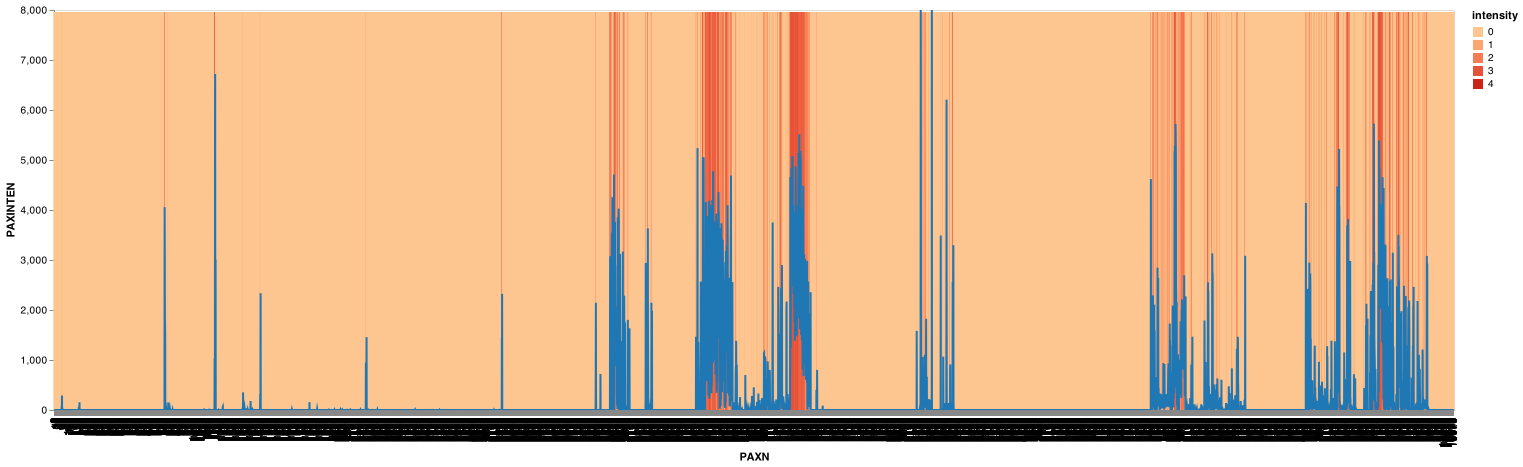

In [81]:
(
    alt.Chart(paxraw_sample)
    .mark_bar(width=1)
    .encode(
        x="PAXN:O",
        y=alt.value(400),
        y2=alt.value(2),
        color=alt.Color("intensity", scale=alt.Scale(scheme="orangered"))
        # scale=alt.Scale(range=["white", "grey"])),
    )
    + alt.Chart(paxraw_sample)
    .mark_line(color="#1f77b4", clip=True)
    .encode(x="PAXN:O", y=alt.Y("PAXINTEN", scale=alt.Scale(domain=[0, 8000])))
).properties(width=1400, height=400)

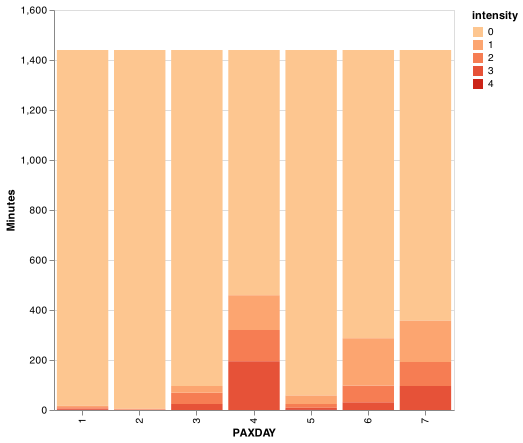

In [82]:
(
    alt.Chart(paxraw_sample)
    .mark_bar()
    .encode(
        x="PAXDAY:O",
        y=alt.Y("count()", title="Minutes"),
        color=alt.Color("intensity", scale=alt.Scale(scheme="orangered"))
        # scale=alt.Scale(range=["white", "grey"])),
    )
).properties(width=400, height=400)

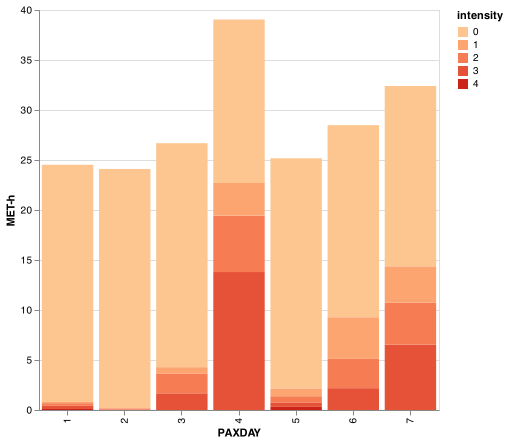

In [83]:
(
    alt.Chart(paxraw_sample)
    .mark_bar()
    .encode(
        x="PAXDAY:O",
        y=alt.Y("sum(METh)", title="MET-h"),
        color=alt.Color("intensity", scale=alt.Scale(scheme="orangered"))
        # scale=alt.Scale(range=["white", "grey"])),
    )
).properties(width=400, height=400)

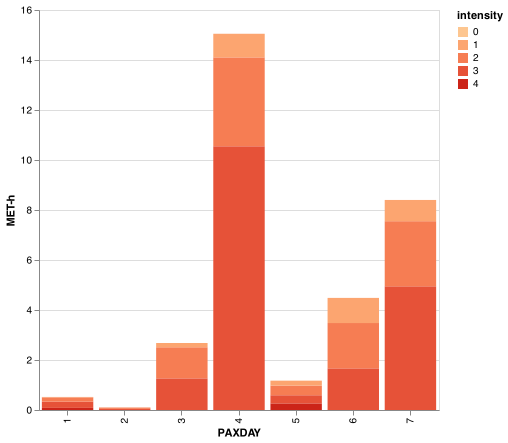

In [84]:
(
    alt.Chart(paxraw_sample)
    .mark_bar()
    .encode(
        x="PAXDAY:O",
        y=alt.Y("sum(activeMETh)", title="MET-h"),
        color=alt.Color("intensity", scale=alt.Scale(scheme="orangered"))
        # scale=alt.Scale(range=["white", "grey"])),
    )
).properties(width=400, height=400)

## Check for overlap on intensity bounts

First sum it up

In [85]:
paxraw.loc[
    :,
    [
        "worn",
        "sed_bout",
        "low_bout",
        "light_bout",
        "moderate_bout",
        "vigorous_bout",
        "no_bout",
    ],
].sum(axis=0)

worn             33134853.0
sed_bout           811951.0
low_bout          5017360.0
light_bout         602056.0
moderate_bout      230393.0
vigorous_bout      832449.0
no_bout          26473093.0
dtype: float64

From before the generalized numba function:
```
"worn             34326726.0\n",
"sed_bout         10920764.0\n",
"low_bout           604376.0\n",
"light_bout          62892.0\n",
"moderate_bout       56051.0\n",
"vigorous_bout      395787.0\n",
"no_bout          22352901.0\n",
```

In [86]:
((paxraw["worn"] == 1) & (paxraw["sed_bout"] == 0)).sum()

32322902

In [87]:
((paxraw["worn"] == 1) & (paxraw["low_bout"] == 1)).sum()

5017360

In [88]:
((paxraw["sed_bout"] == 1) & (paxraw["low_bout"] == 1)).sum()

0

In [89]:
((paxraw["sed_bout"] == 1) & (paxraw["light_bout"] == 1)).sum()

0

In [90]:
((paxraw["sed_bout"] == 1) & (paxraw["moderate_bout"] == 1)).sum()

0

In [91]:
((paxraw["sed_bout"] == 1) & (paxraw["vigorous_bout"] == 1)).sum()

0

# Get valid days and other filters

## Worn minutes by person-day to compute `valid_day`

In [92]:
# sum minutes of wear and activity counts per day
worn_minutes = paxraw.groupby(["SEQN", "PAXDAY"]).agg({"worn": [np.sum]})

worn_minutes.columns = flatten_columns(worn_minutes.columns.values)

In [93]:
# compute valid days
worn_minutes["valid_day"] = (
    worn_minutes["worn"]["sum"] > (min_worn_hours_threshold * MINUTES_PER_HOUR)
) * 1

In [94]:
worn_minutes.head(15)

worn valid_day
                sum          
SEQN  PAXDAY                 
21005 1       202.0         0
      2        76.0         0
      3       243.0         0
      4       873.0         1
      5       203.0         0
      6       681.0         1
      7       875.0         1
21006 1       960.0         1
      2       712.0         1
      3       597.0         0
      4       448.0         0
      5       581.0         0
      6       615.0         1
      7       650.0         1
21007 1       737.0         1

In [95]:
worn_minutes.columns = flatten_columns(worn_minutes.columns.values)

In [96]:
worn_minutes.head(15)

worn_sum  valid_day
SEQN  PAXDAY                     
21005 1          202.0          0
      2           76.0          0
      3          243.0          0
      4          873.0          1
      5          203.0          0
      6          681.0          1
      7          875.0          1
21006 1          960.0          1
      2          712.0          1
      3          597.0          0
      4          448.0          0
      5          581.0          0
      6          615.0          1
      7          650.0          1
21007 1          737.0          1

## Other indicators at person-day level that can be used to filter

In [97]:
agg_columns = ["PAXINTEN", "max_intensity", "out_of_calibration", "unreliable"]

In [98]:
paxraw["max_intensity"] = (paxraw.PAXINTEN == 32767) * 1
paxraw["out_of_calibration"] = (paxraw.PAXCAL == 2) * 1
paxraw["unreliable"] = (paxraw.PAXSTAT == 2) * 1

In [99]:
if "PAXSTEP" not in paxraw.columns:
    paxraw["PAXSTEP"] = 0
    paxraw["zero_steps_with_intensity"] = 0
else:
    paxraw["zero_steps_with_intensity"] = ((paxraw.PAXINTEN > 250) & (paxraw.PAXSTEP == 0)) * 1

In [100]:
paxraw["too_many_steps"] = (paxraw.PAXSTEP > 200) * 1

In [101]:
# add a variable for steps_filtered, summing steps only if we have intensity over 500
paxraw["steps_filtered_500"] = 0
paxraw.loc[paxraw.PAXINTEN >= 500, "steps_filtered_500"] = paxraw.PAXSTEP
paxraw["steps_filtered_300"] = 0
paxraw.loc[paxraw.PAXINTEN >= 300, "steps_filtered_300"] = paxraw.PAXSTEP

In [102]:
agg_columns += [
    "zero_steps_with_intensity",
    "too_many_steps",
    "steps_filtered_500",
    "steps_filtered_300",
]

In [103]:
tudor2009_filters = (
    paxraw.groupby(["SEQN", "PAXDAY"])
    .agg({col: [np.sum, "last"] for col in agg_columns})
    .reset_index()
)
tudor2009_filters.columns = flatten_columns(tudor2009_filters.columns.values)

In [104]:
tudor2009_filters.head(15)

,SEQN,PAXDAY,PAXINTEN_sum,PAXINTEN_last,max_intensity_sum,max_intensity_last,out_of_calibration_sum,out_of_calibration_last,unreliable_sum,unreliable_last,zero_steps_with_intensity_sum,zero_steps_with_intensity_last,too_many_steps_sum,too_many_steps_last,steps_filtered_500_sum,steps_filtered_500_last,steps_filtered_300_sum,steps_filtered_300_last
0,21005,1,32695,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,21005,2,5380,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,21005,3,143783,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,21005,4,851618,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,21005,5,74453,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,21005,6,249123,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,21005,7,469084,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,21006,1,217932,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,21006,2,69560,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,21006,3,206583,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Join all person-day level indicators

In [105]:
d_people_days = tudor2009_filters.merge(worn_minutes, how="inner", on=["SEQN", "PAXDAY"])

In [106]:
d_people_days.head(15)

,SEQN,PAXDAY,PAXINTEN_sum,PAXINTEN_last,max_intensity_sum,max_intensity_last,out_of_calibration_sum,out_of_calibration_last,unreliable_sum,unreliable_last,zero_steps_with_intensity_sum,zero_steps_with_intensity_last,too_many_steps_sum,too_many_steps_last,steps_filtered_500_sum,steps_filtered_500_last,steps_filtered_300_sum,steps_filtered_300_last,worn_sum,valid_day
0,21005,1,32695,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,202.0,0
1,21005,2,5380,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,76.0,0
2,21005,3,143783,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,243.0,0
3,21005,4,851618,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,873.0,1
4,21005,5,74453,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,203.0,0
5,21005,6,249123,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,681.0,1
6,21005,7,469084,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,875.0,1
7,21006,1,217932,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,960.0,1
8,21006,2,69560,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,712.0,1
9,21006,3,206583,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,597.0,0


In [107]:
parquetfile = datadir / f"paxraw_{CHAR_LOOKUP[year].lower()}_people_days.parquet"
parquetfile

PosixPath('~/projects/2022/07-nhanes-analysis/data/raw/2003-2004/paxraw_c_people_days.parquet')

In [108]:
d_people_days.to_parquet(parquetfile)

## Sum up to person level

In [109]:
d_people = d_people_days.groupby("SEQN").agg(
    {
        "zero_steps_with_intensity_sum": np.sum,
        "too_many_steps_sum": np.sum,
        "max_intensity_sum": np.sum,
        "out_of_calibration_sum": np.sum,
        "out_of_calibration_last": "last",
        "unreliable_sum": np.sum,
        "unreliable_last": "last",
        "steps_filtered_500_sum": np.mean,
        "steps_filtered_300_sum": np.mean,
        "valid_day": np.sum,
        "PAXINTEN_sum": np.mean,
    }
)

In [110]:
d_people.head(15)

,zero_steps_with_intensity_sum,too_many_steps_sum,max_intensity_sum,out_of_calibration_sum,out_of_calibration_last,unreliable_sum,unreliable_last,steps_filtered_500_sum,steps_filtered_300_sum,valid_day,PAXINTEN_sum
SEQN,,,,,,,,,,,
21005,0,0,0,0,0,0,0,0.0,0.0,3,260876.571429
21006,0,0,0,0,0,0,0,0.0,0.0,4,137189.571429
21007,0,0,0,0,0,0,0,0.0,0.0,7,361203.714286
21008,0,0,0,0,0,0,0,0.0,0.0,3,237395.142857
21009,0,0,0,0,0,0,0,0.0,0.0,7,409360.142857
21010,0,0,0,0,0,0,0,0.0,0.0,7,286408.571429
21012,0,0,0,0,0,0,0,0.0,0.0,7,130833.428571
21013,0,0,0,10080,1,0,0,0.0,0.0,5,173304.142857
21015,0,0,0,0,0,0,0,0.0,0.0,7,102570.571429


In [111]:
d_people.shape

(7176, 11)

In [112]:
parquetfile = datadir / f"paxraw_{CHAR_LOOKUP[year].lower()}_people.parquet"
parquetfile

PosixPath('~/projects/2022/07-nhanes-analysis/data/raw/2003-2004/paxraw_c_people.parquet')

In [113]:
d_people.to_parquet(parquetfile)

## Use the indicators to filter to people with reliable data

In [114]:
d_reliable = d_people.loc[
    (d_people.zero_steps_with_intensity_sum <= 10)
    & (d_people.too_many_steps_sum <= 10)
    & (d_people.max_intensity_sum <= 10)
    & (~d_people.out_of_calibration_last)
    & (d_people.unreliable_sum <= 10)
    & (d_people.steps_filtered_500_sum <= 200000),
    :,
]
d_reliable.head(15)

,zero_steps_with_intensity_sum,too_many_steps_sum,max_intensity_sum,out_of_calibration_sum,out_of_calibration_last,unreliable_sum,unreliable_last,steps_filtered_500_sum,steps_filtered_300_sum,valid_day,PAXINTEN_sum
SEQN,,,,,,,,,,,
21005,0,0,0,0,0,0,0,0.0,0.0,3,260876.571429
21006,0,0,0,0,0,0,0,0.0,0.0,4,137189.571429
21007,0,0,0,0,0,0,0,0.0,0.0,7,361203.714286
21008,0,0,0,0,0,0,0,0.0,0.0,3,237395.142857
21009,0,0,0,0,0,0,0,0.0,0.0,7,409360.142857
21010,0,0,0,0,0,0,0,0.0,0.0,7,286408.571429
21012,0,0,0,0,0,0,0,0.0,0.0,7,130833.428571
21015,0,0,0,0,0,0,0,0.0,0.0,7,102570.571429
21017,0,0,0,0,0,0,0,0.0,0.0,6,359232.285714


In [115]:
d_reliable.shape

(6807, 11)

In [116]:
parquetfile = datadir / f"paxraw_{CHAR_LOOKUP[year].lower()}_reliable_people.parquet"
parquetfile

PosixPath('~/projects/2022/07-nhanes-analysis/data/raw/2003-2004/paxraw_c_reliable_people.parquet')

In [117]:
d_reliable.to_parquet(parquetfile)

## Use filtered people to select rows from full data

In [118]:
paxraw_reliable = paxraw.merge(
    worn_minutes.loc[worn_minutes.valid_day == 1, :], on=["SEQN", "PAXDAY"]
).merge(d_reliable.loc[:, []], how="inner", on="SEQN")
paxraw_reliable.head(10)

,SEQN,PAXSTAT,PAXCAL,PAXDAY,PAXN,PAXHOUR,PAXMINUT,PAXINTEN,MET,worn,vigorous_bout,moderate_bout,light_bout,low_bout,sed_bout,no_bout,intensity,METh,activeMETh,max_intensity,out_of_calibration,unreliable,PAXSTEP,zero_steps_with_intensity,too_many_steps,steps_filtered_500,steps_filtered_300,worn_sum,valid_day
0,21005,1,1,4,4321,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.016667,0.0,0,0,0,0,0,0,0,0,873.0,1
1,21005,1,1,4,4322,0,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.016667,0.0,0,0,0,0,0,0,0,0,873.0,1
2,21005,1,1,4,4323,0,2,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.016667,0.0,0,0,0,0,0,0,0,0,873.0,1
3,21005,1,1,4,4324,0,3,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.016667,0.0,0,0,0,0,0,0,0,0,873.0,1
4,21005,1,1,4,4325,0,4,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.016667,0.0,0,0,0,0,0,0,0,0,873.0,1
5,21005,1,1,4,4326,0,5,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.016667,0.0,0,0,0,0,0,0,0,0,873.0,1
6,21005,1,1,4,4327,0,6,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.016667,0.0,0,0,0,0,0,0,0,0,873.0,1
7,21005,1,1,4,4328,0,7,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.016667,0.0,0,0,0,0,0,0,0,0,873.0,1
8,21005,1,1,4,4329,0,8,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.016667,0.0,0,0,0,0,0,0,0,0,873.0,1
9,21005,1,1,4,4330,0,9,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.016667,0.0,0,0,0,0,0,0,0,0,873.0,1


In [119]:
paxraw_reliable.shape

(46054080, 29)

In [120]:
paxraw_reliable.shape

(46054080, 29)

## Save parquet

In [121]:
parquetfile = datadir / f"paxraw_{CHAR_LOOKUP[year].lower()}_met_worn_bouts_reliable.parquet"
parquetfile

PosixPath('~/projects/2022/07-nhanes-analysis/data/raw/2003-2004/paxraw_c_met_worn_bouts_reliable.parquet')

In [122]:
paxraw_reliable.to_parquet(parquetfile)

# Look at intensity distribution and METh thresholds

### Group by intensity to sum MET-h levels across days

In [123]:
groupedMETh = (
    paxraw_sample.groupby(["intensity", "PAXDAY"])
    .agg({"activeMETh": np.sum})
    .groupby(["intensity"])
    .agg({"activeMETh": np.mean})
)
groupedMETh

,activeMETh
intensity,
0,0.000000
1,0.456977
2,1.403818
3,2.719815
4,0.050037


In [124]:
groupedMETh.sum()

activeMETh    4.630647
dtype: float64

This is the same as just taking the mean of the sum (without grouping by intensity in the middle):

In [125]:
paxraw_sample.groupby(["PAXDAY"]).agg({"activeMETh": np.sum}).mean()

activeMETh    4.630647
dtype: float64

In [126]:
paxraw_reliable.groupby(["SEQN", "intensity", "PAXDAY"]).agg({"activeMETh": np.sum}).head()

activeMETh
SEQN  intensity PAXDAY            
21005 0         1              0.0
                2              0.0
                3              0.0
                4              0.0
                5              0.0

In [127]:
paxraw_reliable.groupby(["SEQN", "intensity", "PAXDAY"]).agg({"activeMETh": np.sum}).groupby(
    ["SEQN", "intensity"]
).agg({"activeMETh": np.mean}).head()

activeMETh
SEQN  intensity            
21005 0            0.000000
      1            0.399830
      2            1.139354
      3            2.451585
      4            0.000000

In [128]:
minutes_at_intensity = (
    paxraw_reliable.groupby(["SEQN", "intensity", "PAXDAY"])
    .agg({"activeMETh": "count"})
    .groupby(["SEQN", "intensity"])
    .agg({"activeMETh": np.mean})
    .groupby(["intensity"])
    .agg({"activeMETh": np.mean})
)
minutes_at_intensity

,activeMETh
intensity,
0,770.206608
1,183.109975
2,64.498677
3,22.306610
4,1.377937


In [129]:
METh_at_intensity = (
    paxraw_reliable.groupby(["SEQN", "intensity", "PAXDAY"])
    .agg({"activeMETh": np.sum})
    .groupby(["SEQN", "intensity"])
    .agg({"activeMETh": np.mean})
    .groupby(["intensity"])
    .agg({"activeMETh": np.mean})
)
METh_at_intensity

,activeMETh
intensity,
0,0.000000
1,1.066653
2,1.657452
3,1.174534
4,0.124645


In [130]:
minutes_METh = minutes_at_intensity.rename(columns={"activeMETh": "minutes"}).merge(
    METh_at_intensity, how="inner", on="intensity"
)
minutes_METh

,minutes,activeMETh
intensity,,
0,770.206608,0.000000
1,183.109975,1.066653
2,64.498677,1.657452
3,22.306610,1.174534
4,1.377937,0.124645


In [131]:
minutes_METh_stack = (
    pd.concat(
        [
            minutes_at_intensity.assign(metric="minutes"),
            METh_at_intensity.assign(metric="MET", activeMETh=lambda d: d.activeMETh * 60),
        ]
    )
    .reset_index()
    .merge(
        pd.DataFrame({"label": labels, "intensity": range(5)}),
        how="left",
        on="intensity",
    )
)
minutes_METh_stack

,intensity,activeMETh,metric,label
0,0,770.206608,minutes,Sedentary
1,1,183.109975,minutes,Low
2,2,64.498677,minutes,Light
3,3,22.306610,minutes,Moderate
4,4,1.377937,minutes,Vigorous
5,0,0.000000,MET,Sedentary
6,1,63.999158,MET,Low
7,2,99.447142,MET,Light
8,3,70.472058,MET,Moderate
9,4,7.478697,MET,Vigorous


### MET Minutes vs Minutes by intensity level

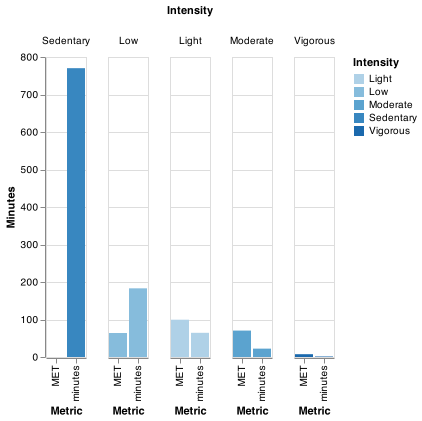

In [132]:
alt.Chart(minutes_METh_stack).mark_bar().encode(
    x=alt.X("metric:N", title="Metric"),
    y=alt.Y("activeMETh:Q", title="Minutes"),
    color=alt.Color("label:O", title="Intensity"),
    column=alt.Column(
        "label:O", title="Intensity", sort=alt.SortField("intensity", order="ascending")
    ),
)

Skip sedentary - no METs

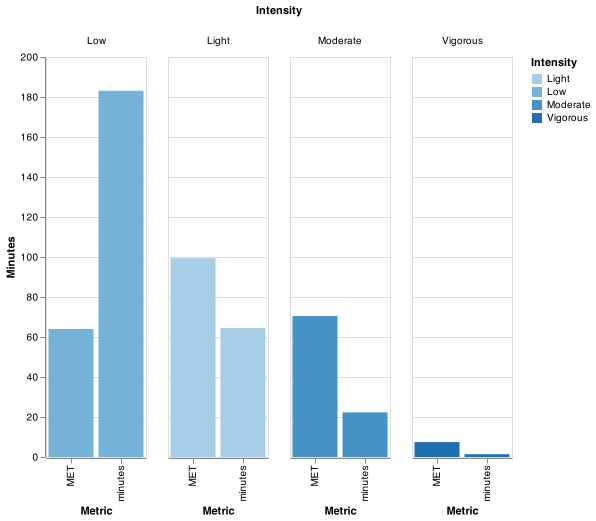

In [133]:
alt.Chart(minutes_METh_stack.loc[minutes_METh_stack.intensity > 0, :]).mark_bar().encode(
    x=alt.X("metric:N", title="Metric"),
    y=alt.Y("activeMETh:Q", title="Minutes"),
    color=alt.Color("label:O", title="Intensity"),
    column=alt.Column(
        "label:O", title="Intensity", sort=alt.SortField("intensity", order="ascending")
    ),
).properties(width=100, height=400)

## Distribution of weekly METh

In [134]:
(
    paxraw_reliable.groupby(["SEQN", "intensity", "PAXDAY"])
    .agg({"activeMETh": np.sum})
    .groupby(["SEQN", "intensity"])
    .agg({"activeMETh": np.mean})
    .groupby(["SEQN"])
    .agg({"activeMETh": np.sum})
).mean() * 7

activeMETh    28.16299
dtype: float64

In [135]:
METh = (
    paxraw_reliable.groupby(["SEQN", "intensity", "PAXDAY"])
    .agg({"activeMETh": np.sum})
    .groupby(["SEQN", "intensity"])
    .agg({"activeMETh": np.mean})
    .groupby(["SEQN"])
    .agg({"activeMETh": np.sum})
).assign(weeklyMETh=lambda d: d.activeMETh * 7)
METh

,activeMETh,weeklyMETh
SEQN,,
21005,3.990769,27.935385
21006,1.173526,8.214684
21007,6.617710,46.323967
21008,1.590891,11.136237
21009,7.702531,53.917718
...,...,...
31114,3.343096,23.401669
31115,1.903368,13.323576
31119,6.989679,48.927752


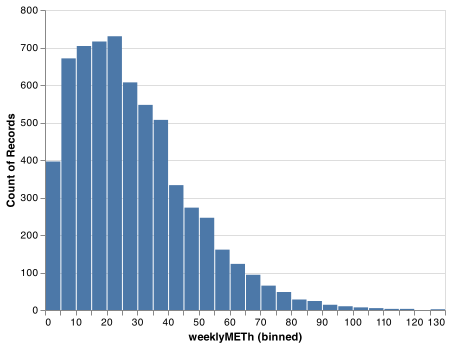

In [136]:
alt.Chart(METh).mark_bar().encode(
    alt.X("weeklyMETh:Q", bin=alt.BinParams(maxbins=35)),
    y="count()",
)

## Look at different METh thresholds and % of people getting rewards (and total utilization)

In [137]:
cut, cuts = pd.qcut(METh.weeklyMETh, 10, retbins=True)
cut

SEQN
21005     (24.555, 29.75]
21006     (6.746, 11.633]
21007    (42.428, 54.022]
21008     (6.746, 11.633]
21009    (42.428, 54.022]
               ...       
31114    (20.245, 24.555]
31115    (11.633, 15.772]
31119    (42.428, 54.022]
31121    (20.245, 24.555]
31124    (15.772, 20.245]
Name: weeklyMETh, Length: 6317, dtype: category
Categories (10, interval[float64, right]): [(0.16, 6.746] < (6.746, 11.633] < (11.633, 15.772] < (15.772, 20.245] ... (29.75, 35.486] < (35.486, 42.428] < (42.428, 54.022] < (54.022, 129.914]]

In [138]:
cuts

array([  0.16051046,   6.74648629,  11.63271596,  15.77151506,
        20.24492932,  24.55485369,  29.75031654,  35.4864207 ,
        42.42808025,  54.0221748 , 129.91367408])

In [139]:
cut.cat.categories

IntervalIndex([(0.16, 6.746], (6.746, 11.633], (11.633, 15.772], (15.772, 20.245], (20.245, 24.555], (24.555, 29.75], (29.75, 35.486], (35.486, 42.428], (42.428, 54.022], (54.022, 129.914]], dtype='interval[float64, right]')

In [140]:
utilization = pd.DataFrame(
    {
        "target": np.linspace(cuts[1], cuts[-2], num=50),
        "Total Utilization": [
            np.minimum(METh.weeklyMETh.values / x, 1).mean()
            for x in np.linspace(cuts[1], cuts[-2], num=50)
        ],
        "Max Rewards": [
            (METh.weeklyMETh.values / x >= 1).sum() / METh.shape[0]
            for x in np.linspace(cuts[1], cuts[-2], num=50)
        ],
    }
)

In [141]:
utilization.head()

,target,Total Utilization,Max Rewards
0,6.746486,0.961888,0.899953
1,7.711296,0.952972,0.880006
2,8.676106,0.943589,0.858952
3,9.640916,0.934003,0.836948
4,10.605726,0.924469,0.820959


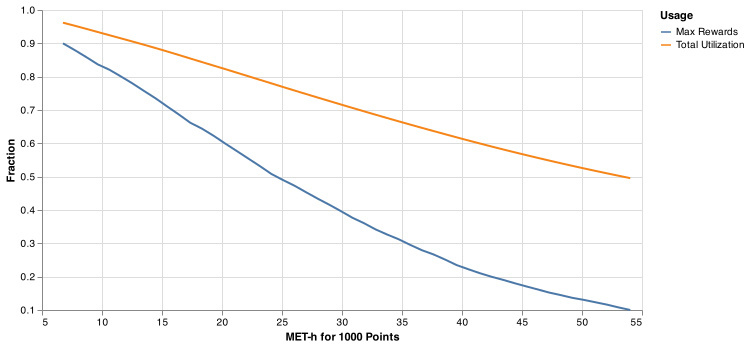

In [142]:
alt.Chart(utilization).mark_line().transform_fold(
    fold=["Total Utilization", "Max Rewards"], as_=["variable", "value"]
).encode(
    alt.X("target:Q", title="MET-h for 1000 Points"),
    alt.Y("value:Q", title="Fraction", scale=alt.Scale(zero=False)),
    alt.Color("variable:N", title="Usage"),
).properties(
    width=600
)

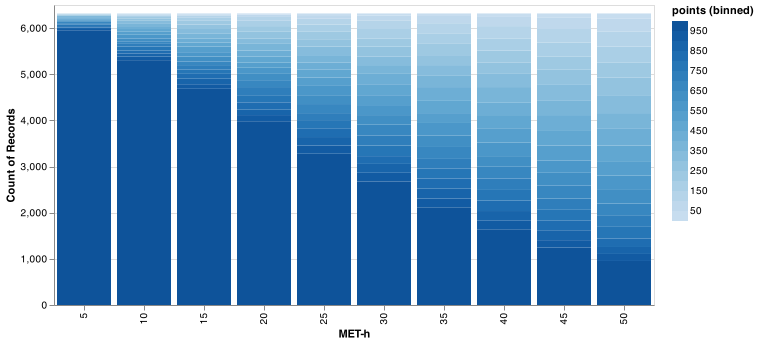

In [143]:
alt.Chart(
    pd.concat(
        [
            pd.DataFrame({"points": np.minimum(METh.weeklyMETh.values / x, 1) * 1000, "MET-h": x})
            for x in np.arange(5, 55, 5)
        ]
    )
).mark_bar().encode(
    alt.Color("points:Q", bin=alt.BinParams(maxbins=20)),
    alt.Y("count()"),
    alt.X("MET-h:O"),
).properties(
    width=600
)

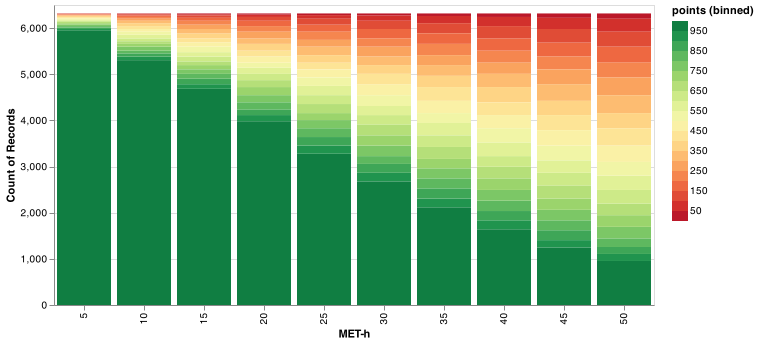

In [144]:
alt.Chart(
    pd.concat(
        [
            pd.DataFrame({"points": np.minimum(METh.weeklyMETh.values / x, 1) * 1000, "MET-h": x})
            for x in np.arange(5, 55, 5)
        ]
    )
).mark_bar().encode(
    alt.Color(
        "points:Q",
        bin=alt.BinParams(maxbins=20),
        scale=alt.Scale(scheme="redyellowgreen"),
    ),
    alt.Y("count()"),
    alt.X("MET-h:O"),
).properties(
    width=600
)

## Ena's chart of points by intensity for different amounts of points earned

In [145]:
all_intensities = pd.DataFrame(
    {
        "SEQN": np.repeat(pd.unique(paxraw_reliable.SEQN.values), 5),
        "intensity": np.tile(np.arange(5), pd.unique(paxraw_reliable.SEQN.values).shape[0]),
    }
)
all_intensities.head(11)

,SEQN,intensity
0,21005,0
1,21005,1
2,21005,2
3,21005,3
4,21005,4
5,21006,0
6,21006,1
7,21006,2
8,21006,3
9,21006,4


In [146]:
points_by_intensity = (
    paxraw_reliable.groupby(["SEQN", "intensity", "PAXDAY"], dropna=False)
    .agg({"activeMETh": np.sum, "worn": np.sum})
    .groupby(["SEQN", "intensity"], dropna=False)
    .agg({"activeMETh": np.mean, "worn": np.mean})
    # fill in blank intensities
    .merge(all_intensities, how="outer", on=list(all_intensities.columns))
    .fillna(0)
    # calc points
    .assign(weeklyMETh=lambda d: d.activeMETh * 7, points=lambda d: d.weeklyMETh / 25 * 1000)
    .rename(columns={"worn": "dailyMinutes"})
    .reset_index()
)
points_by_intensity.head()

,index,SEQN,intensity,activeMETh,dailyMinutes,weeklyMETh,points
0,0,21005,0,0.000000,189.428571,0.000000,0.000000
1,1,21005,1,0.399830,70.428571,2.798813,111.952525
2,2,21005,2,1.139354,41.142857,7.975476,319.019048
3,3,21005,3,2.451585,46.000000,17.161096,686.443830
4,4,21005,4,0.000000,0.000000,0.000000,0.000000


In [147]:
points_by_person = (
    points_by_intensity.groupby("SEQN")
    .agg({"points": np.sum})
    .assign(
        points_capped=lambda d: np.minimum(d.points, 1000),
        point_bin=lambda d: pd.cut(d.points_capped, np.arange(11) * 100, right=True),
    )
)
points_by_person

,points,points_capped,point_bin
SEQN,,,
21005,1117.415403,1000.000000,"(900, 1000]"
21006,328.587368,328.587368,"(300, 400]"
21007,1852.958677,1000.000000,"(900, 1000]"
21008,445.449475,445.449475,"(400, 500]"
21009,2156.708738,1000.000000,"(900, 1000]"
...,...,...,...
31114,936.066777,936.066777,"(900, 1000]"
31115,532.943052,532.943052,"(500, 600]"
31119,1957.110095,1000.000000,"(900, 1000]"


In [148]:
point_thresholds_by_intensity = (
    points_by_intensity.merge(points_by_person, how="left", on="SEQN")
    .assign(
        points_relative=lambda d: d.points_x / d.points_y,
        dailyMinutesCapped=lambda d: d.dailyMinutes * d.points_capped / d.points_y,
    )
    .groupby(["point_bin", "intensity"], dropna=False)
    .agg(
        {
            "points_relative": np.mean,
            "points_capped": np.mean,
            "dailyMinutesCapped": np.mean,
        }
    )
    .assign(
        points=lambda d: d.points_relative * d.points_capped,
    )
    .reset_index()
    .assign(point_bin=lambda d: d.point_bin.astype("str"))
    .merge(pd.DataFrame({"label": labels, "intensity": np.arange(5)}), how="left", on="intensity")
)
point_thresholds_by_intensity

,point_bin,intensity,points_relative,points_capped,dailyMinutesCapped,points,label
0,"(0, 100]",0,0.000000,64.230375,214.155280,0.000000,Sedentary
1,"(0, 100]",1,0.564052,64.230375,32.058385,36.229246,Low
2,"(0, 100]",2,0.297794,64.230375,2.867081,19.127398,Light
3,"(0, 100]",3,0.125661,64.230375,0.581366,8.071232,Moderate
4,"(0, 100]",4,0.012494,64.230375,0.024845,0.802498,Vigorous
5,"(100, 200]",0,0.000000,152.980101,232.245552,0.000000,Sedentary
6,"(100, 200]",1,0.485225,152.980101,59.376716,74.229711,Low
7,"(100, 200]",2,0.358207,152.980101,7.957295,54.798555,Light
8,"(100, 200]",3,0.149147,152.980101,1.643111,22.816494,Moderate
9,"(100, 200]",4,0.007421,152.980101,0.045247,1.135342,Vigorous


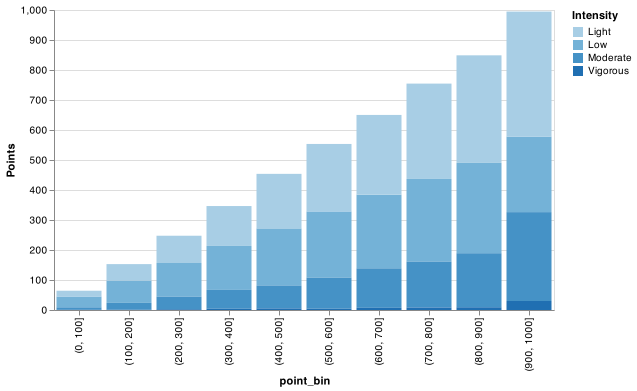

In [149]:
alt.Chart(
    point_thresholds_by_intensity.loc[point_thresholds_by_intensity.intensity > 0, :]
).mark_bar().encode(
    alt.X("point_bin:O"),
    alt.Y("points:Q", title="Points"),
    alt.Color("label:O", title="Intensity", sort=alt.SortField("label", order="ascending")),
).properties(
    width=500
)

### Stack the bar chart

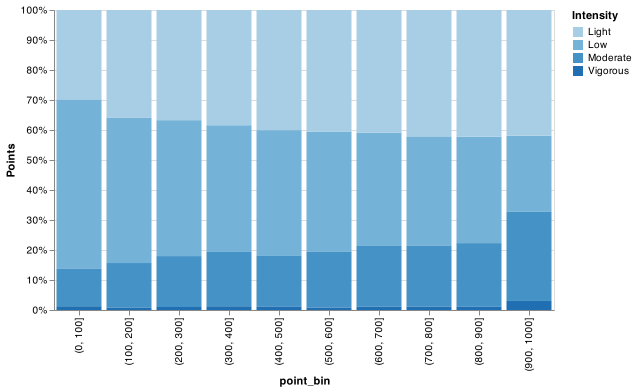

In [150]:
alt.Chart(
    point_thresholds_by_intensity.loc[point_thresholds_by_intensity.intensity > 0, :]
).mark_bar().encode(
    alt.X("point_bin:O"),
    alt.Y("points:Q", title="Points", stack="normalize"),
    alt.Color("label:O", title="Intensity", sort=alt.SortField("label", order="ascending")),
).properties(
    width=500
)

### Convert this to daily times in zones

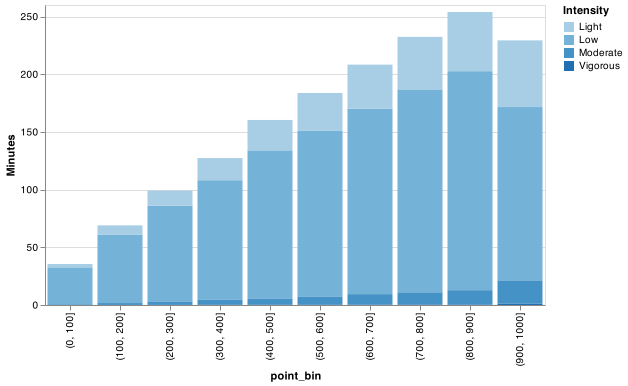

In [151]:
alt.Chart(
    point_thresholds_by_intensity.loc[point_thresholds_by_intensity.intensity > 0, :]
).mark_bar().encode(
    alt.X("point_bin:O"),
    alt.Y("dailyMinutesCapped:Q", title="Minutes"),
    alt.Detail("label:O", title="Intensity"),
    alt.Color("label:O", title="Intensity", sort=alt.SortField("label", order="ascending")),
    tooltip=["label", "dailyMinutesCapped", "point_bin", "points"],
).properties(
    width=500
)

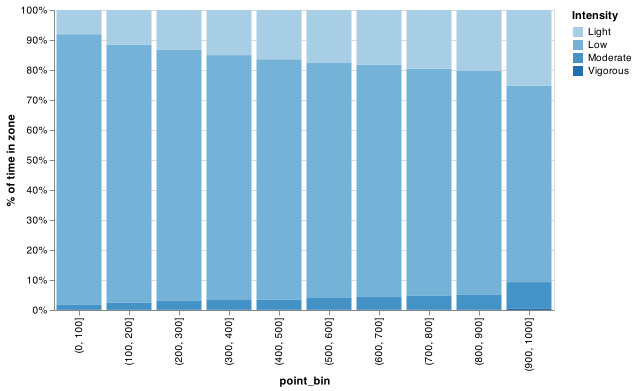

In [152]:
alt.Chart(
    point_thresholds_by_intensity.loc[point_thresholds_by_intensity.intensity > 0, :]
).mark_bar().encode(
    alt.X("point_bin:O"),
    alt.Y("dailyMinutesCapped:Q", title="% of time in zone", stack="normalize"),
    alt.Detail("label:O", title="Intensity"),
    alt.Color("label:O", title="Intensity", sort=alt.SortField("label", order="ascending")),
    tooltip=["label", "dailyMinutesCapped", "point_bin", "points"],
).properties(
    width=500
)

In [153]:
point_thresholds_by_intensity.loc[point_thresholds_by_intensity.intensity > 0, :].pivot(
    index="point_bin", columns="label", values="dailyMinutesCapped"
)

label,Light,Low,Moderate,Vigorous
point_bin,,,,
"(0, 100]",2.867081,32.058385,0.581366,0.024845
"(100, 200]",7.957295,59.376716,1.643111,0.045247
"(200, 300]",13.190181,82.987174,2.911986,0.097302
"(300, 400]",19.157225,103.655172,4.344828,0.173235
"(400, 500]",26.314552,128.510648,5.330524,0.215173
"(500, 600]",32.487659,143.891174,7.204188,0.181750
"(600, 700]",38.087629,160.838733,9.131811,0.285714
"(700, 800]",45.518728,175.909843,10.632404,0.337544
"(800, 900]",51.276165,189.818564,12.457219,0.364782


In [154]:
point_thresholds_by_intensity.loc[point_thresholds_by_intensity.intensity > 0, :].pivot(
    index="point_bin", columns="label", values="dailyMinutesCapped"
).assign(Moderate_and_Vigorous=lambda d: d.Moderate + d.Vigorous * 2).rename(
    columns={"Moderate_and_Vigorous": "Moderate_and_Vigorous".replace("_", " ")}
).loc[
    :, ["Low", "Light", "Moderate and Vigorous"]
].astype(
    "int"
)

label,Low,Light,Moderate and Vigorous
point_bin,,,
"(0, 100]",32,2,0
"(100, 200]",59,7,1
"(200, 300]",82,13,3
"(300, 400]",103,19,4
"(400, 500]",128,26,5
"(500, 600]",143,32,7
"(600, 700]",160,38,9
"(700, 800]",175,45,11
"(800, 900]",189,51,13


In [155]:
point_thresholds_by_intensity.loc[point_thresholds_by_intensity.intensity > 0, :].pivot(
    index="point_bin", columns="label", values="dailyMinutesCapped"
).assign(
    Moderate_and_Vigorous=lambda d: d.Moderate + d.Vigorous * 2,
    Light=lambda d: d.Low * 0.5 + d.Light,
).rename(
    columns={"Moderate_and_Vigorous": "Moderate_and_Vigorous".replace("_", " ")}
).loc[
    :, ["Light", "Moderate and Vigorous"]
].astype(
    "int"
)

label,Light,Moderate and Vigorous
point_bin,,
"(0, 100]",18,0
"(100, 200]",37,1
"(200, 300]",54,3
"(300, 400]",70,4
"(400, 500]",90,5
"(500, 600]",104,7
"(600, 700]",118,9
"(700, 800]",133,11
"(800, 900]",146,13


# Additional plots

## Aggregate to daily

In [156]:
by_day = (
    paxraw.groupby(["SEQN", "PAXDAY"])
    .agg({"PAXSTEP": [sum], "PAXINTEN": [sum, np.mean, max]})
    .reset_index()
)
by_day.head()

SEQN PAXDAY PAXSTEP PAXINTEN                  
                    sum      sum        mean   max
0  21005      1       0    32695   22.704861  6721
1  21005      2       0     5380    3.736111  2336
2  21005      3       0   143783   99.849306  4711
3  21005      4       0   851618  591.401389  5513
4  21005      5       0    74453   51.703472  9313

In [157]:
by_day.shape

(50183, 6)

In [158]:
# by_day.columns = by_day.columns.get_level_values(0)
by_day.columns = flatten_columns(by_day.columns)

In [159]:
by_day.loc[by_day.SEQN == 31128.0, :]

,SEQN,PAXDAY,PAXSTEP_sum,PAXINTEN_sum,PAXINTEN_mean,PAXINTEN_max


## Daily charts

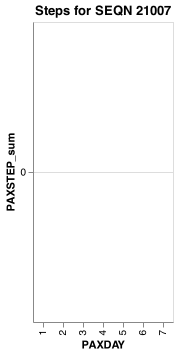

In [160]:
id = 2
alt.Chart(by_day.loc[by_day.SEQN == by_day.SEQN.unique()[id], :]).mark_bar().encode(
    x="PAXDAY:O", y="PAXSTEP_sum"
).properties(title=f"Steps for SEQN {by_day.SEQN.unique()[id]}")

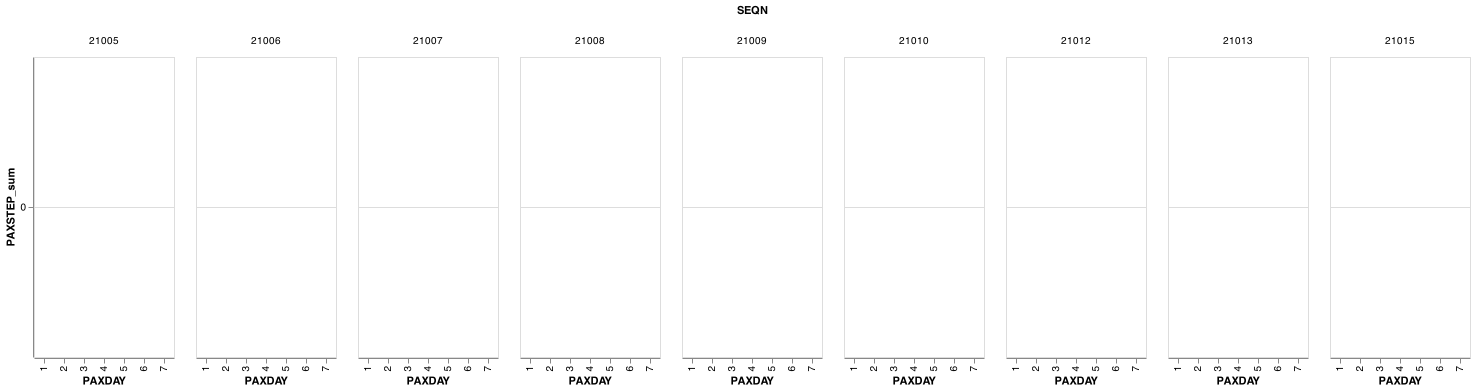

In [161]:
alt.Chart(by_day.loc[by_day.SEQN.isin(by_day.SEQN.unique()[:9]), :]).mark_bar().encode(
    x="PAXDAY:O", y="PAXSTEP_sum", column="SEQN:N"
).properties()

## Individual activity/steps

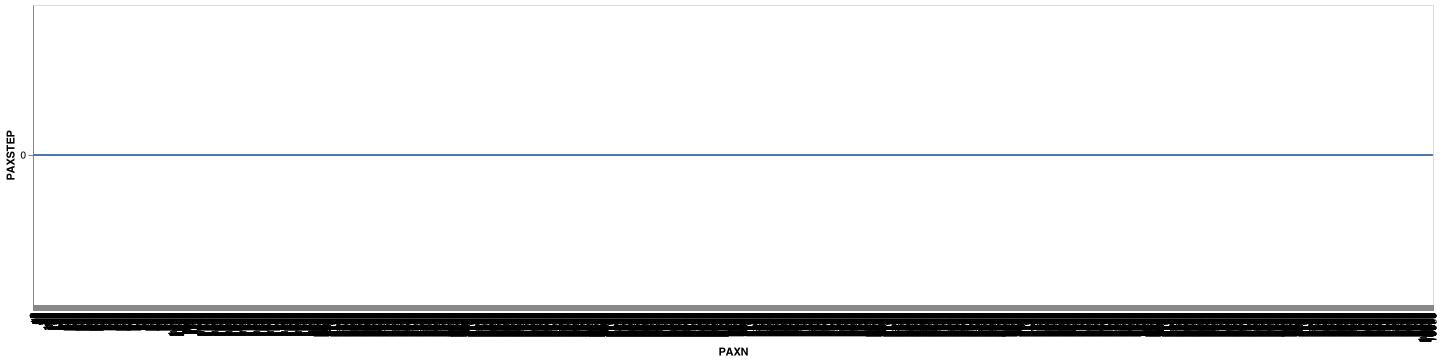

In [162]:
alt.Chart(paxraw.loc[paxraw.SEQN == by_day.SEQN.unique()[0], :]).mark_line().encode(
    x="PAXN:O", y="PAXSTEP"
).properties(width=1400)

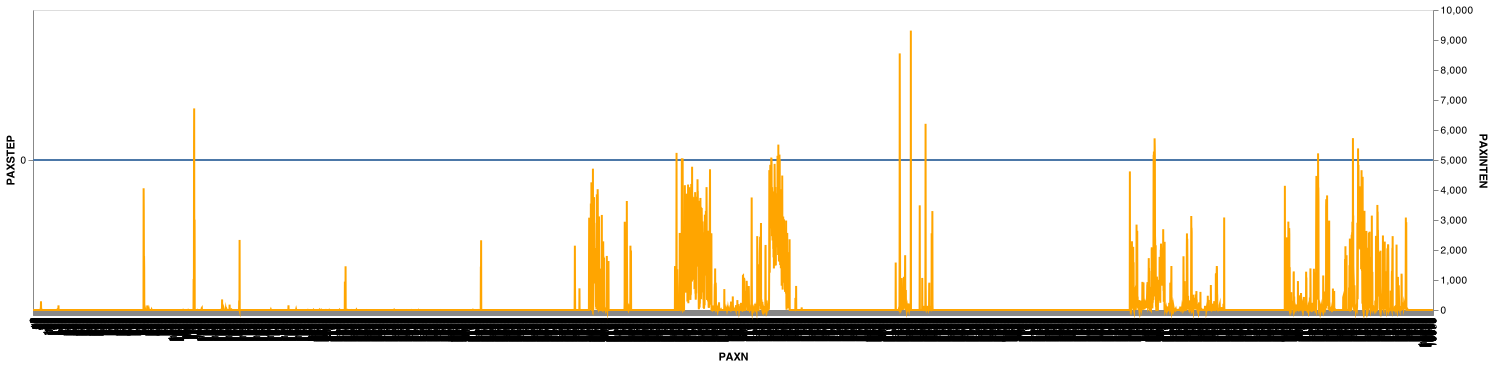

In [163]:
(
    alt.Chart(paxraw.loc[paxraw.SEQN == by_day.SEQN.unique()[0], :])
    .mark_line()
    .encode(x="PAXN:O", y="PAXSTEP")
    + alt.Chart(paxraw.loc[paxraw.SEQN == by_day.SEQN.unique()[0], :])
    .mark_line(color="orange")
    .encode(x="PAXN:O", y="PAXINTEN")
).properties(width=1400).resolve_scale(y="independent")

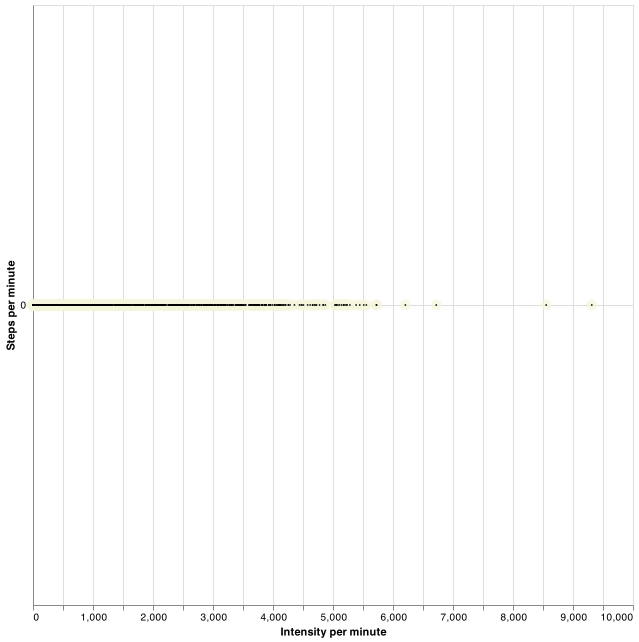

In [164]:
(
    alt.Chart(paxraw.loc[paxraw.SEQN == by_day.SEQN.unique()[0], :])
    .mark_circle(opacity=0.7, color="#F5F5DC", size=120)
    .encode(
        alt.X("PAXINTEN:Q", title="Intensity per minute"),
        alt.Y("PAXSTEP:Q", title="Steps per minute"),
    )
    + alt.Chart(paxraw.loc[paxraw.SEQN == by_day.SEQN.unique()[0], :])
    .mark_circle(opacity=1, color="black", size=3)
    .encode(x="PAXINTEN", y="PAXSTEP")
).properties(width=600, height=600)

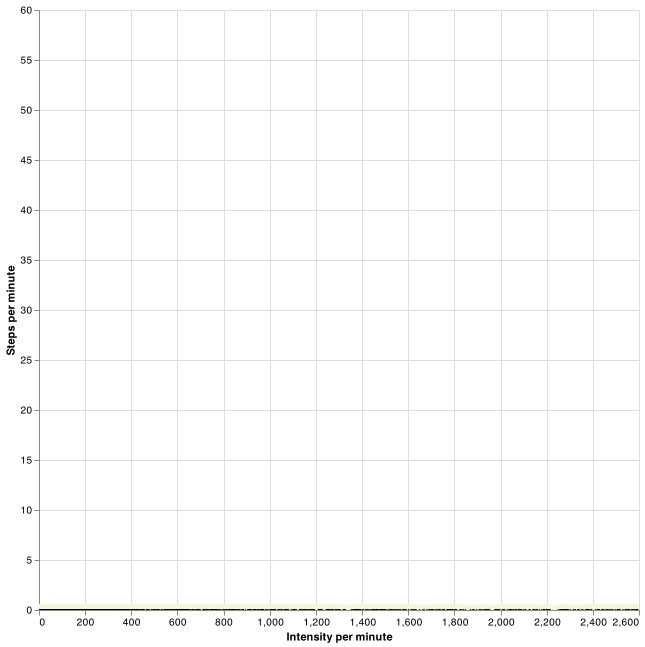

In [165]:
(
    alt.Chart(paxraw.loc[paxraw.SEQN == by_day.SEQN.unique()[0], :])
    .mark_circle(clip=True, opacity=0.7, color="#F5F5DC", size=120)
    .encode(
        alt.X(
            "PAXINTEN:Q",
            title="Intensity per minute",
            scale=alt.Scale(domain=[0, 2500]),
        ),
        alt.Y("PAXSTEP:Q", title="Steps per minute", scale=alt.Scale(domain=[0, 60])),
    )
    + alt.Chart(paxraw.loc[paxraw.SEQN == by_day.SEQN.unique()[0], :])
    .mark_circle(clip=True, opacity=1, color="black", size=3)
    .encode(x="PAXINTEN", y="PAXSTEP")
).properties(width=600, height=600)

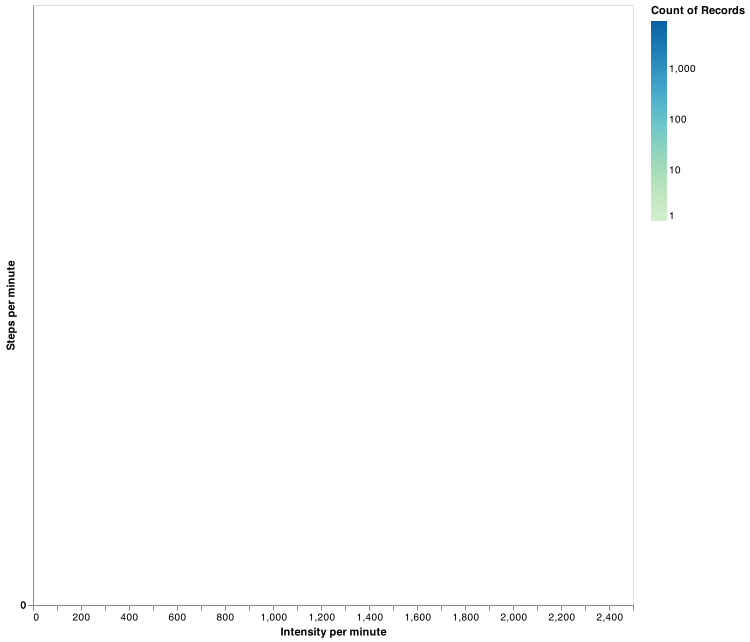

In [166]:
alt.Chart(paxraw.loc[paxraw.SEQN == by_day.SEQN.unique()[0], :]).mark_rect(clip=True).encode(
    alt.X(
        "PAXINTEN:Q",
        title="Intensity per minute",
        scale=alt.Scale(domain=[0, 2500]),
        bin=alt.Bin(maxbins=100),
    ),
    alt.Y(
        "PAXSTEP:Q",
        title="Steps per minute",
        scale=alt.Scale(domain=[0, 60]),
        bin=alt.Bin(maxbins=100),
    ),
    alt.Color("count():Q", scale=alt.Scale(scheme="greenblue", type="log")),
).properties(width=600, height=600)

WARN Infinite extent for field "PAXINTEN": [Infinity, -Infinity]
WARN Infinite extent for field "PAXSTEP": [Infinity, -Infinity]
WARN Infinite extent for field "__count": [Infinity, -Infinity]
WARN Log scale domain includes zero: [,]


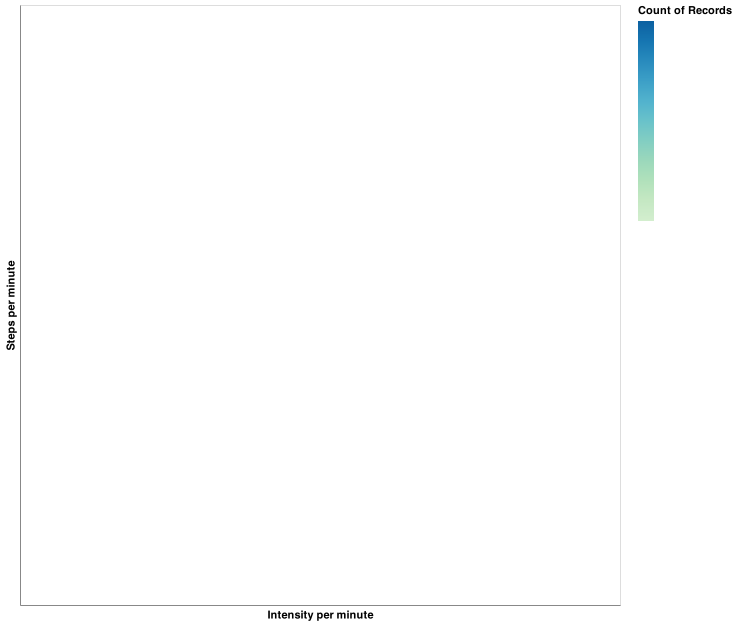

In [167]:
alt.Chart(
    paxraw.loc[
        (paxraw.SEQN == by_day.SEQN.unique()[0]) & (paxraw.PAXINTEN > 0) & (paxraw.PAXSTEP > 0),
        :,
    ]
).mark_rect(clip=True).encode(
    alt.X(
        "PAXINTEN:Q",
        title="Intensity per minute",
        scale=alt.Scale(domain=[0, 2500]),
        bin=alt.Bin(maxbins=100),
    ),
    alt.Y(
        "PAXSTEP:Q",
        title="Steps per minute",
        scale=alt.Scale(domain=[0, 60]),
        bin=alt.Bin(maxbins=100),
    ),
    alt.Color("count():Q", scale=alt.Scale(scheme="greenblue", type="log")),
).properties(
    width=600, height=600
)

## Activity plots for a single participant

In [168]:
person_active_counts = d_people_days.loc[
    :, ["SEQN", "worn_sum", "PAXINTEN_sum", "valid_day"]
].copy()

In [169]:
person_active_counts.columns = ["SEQN", "worn_minutes", "activity_counts", "valid_day"]

In [170]:
person_active_counts.head()

,SEQN,worn_minutes,activity_counts,valid_day
0,21005,202.0,32695,0
1,21005,76.0,5380,0
2,21005,243.0,143783,0
3,21005,873.0,851618,1
4,21005,203.0,74453,0


In [171]:
person_active_counts_summary = (
    person_active_counts.loc[person_active_counts.valid_day == 1, :]
    .groupby(["SEQN"])
    .agg({"worn_minutes": np.mean, "activity_counts": np.mean, "valid_day": "count"})
)
person_active_counts_summary.columns = [
    "daily_worn_minutes_mean",
    "daily_activity_count_sum_mean",
    "n_valid_days",
]
person_active_counts_summary.head()

,daily_worn_minutes_mean,daily_activity_count_sum_mean,n_valid_days
SEQN,,,
21005,809.666667,523275.000000,3
21006,734.250000,117279.250000,4
21007,911.428571,361203.714286,7
21008,788.333333,214938.333333,3
21009,900.285714,409360.142857,7


In [172]:
person_active_counts_summary.shape

(6659, 3)

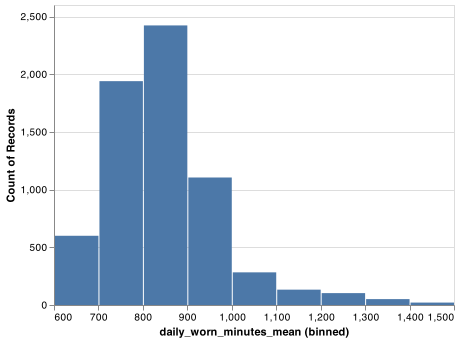

In [173]:
alt.Chart(person_active_counts_summary).mark_bar().encode(
    alt.X("daily_worn_minutes_mean:Q", bin=True),
    y="count()",
)

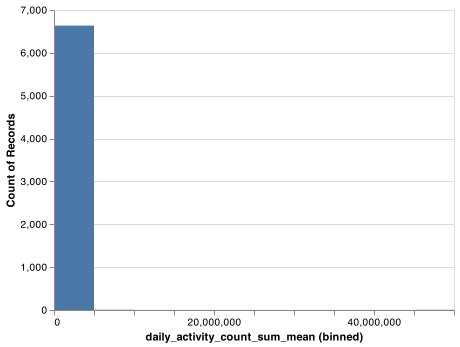

In [174]:
alt.Chart(person_active_counts_summary).mark_bar().encode(
    alt.X("daily_activity_count_sum_mean:Q", bin=True),
    y="count()",
)

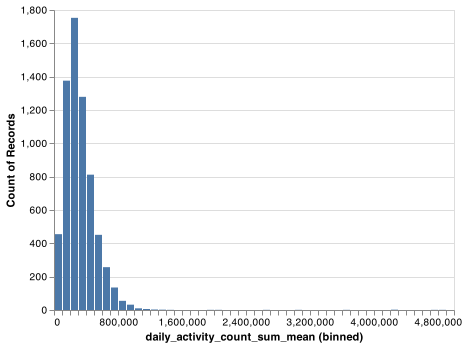

In [175]:
alt.Chart(person_active_counts_summary).mark_bar(clip=True).encode(
    alt.X(
        "daily_activity_count_sum_mean:Q",
        scale=alt.Scale(domain=[0, 5000000]),
        bin=alt.Bin(maxbins=500),
    ),
    y="count()",
)

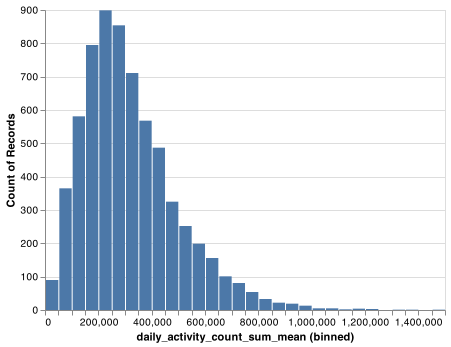

In [176]:
alt.Chart(person_active_counts_summary).mark_bar(clip=True).encode(
    alt.X(
        "daily_activity_count_sum_mean:Q",
        scale=alt.Scale(domain=[0, 1500000]),
        bin=alt.Bin(maxbins=1000),
    ),
    y="count()",
)

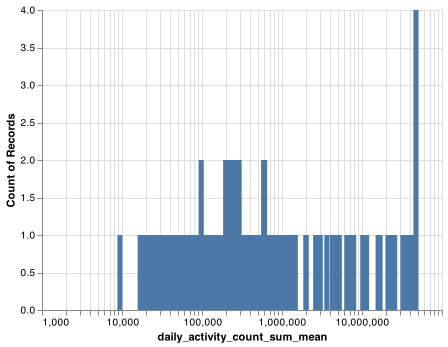

In [177]:
alt.Chart(person_active_counts_summary).mark_bar().encode(
    alt.X("daily_activity_count_sum_mean:Q", scale=alt.Scale(type="log")),
    y="count()",
)

In [178]:
person_active_counts_summary["daily_activity_count_sum_mean_log"] = np.log10(
    person_active_counts_summary["daily_activity_count_sum_mean"]
)

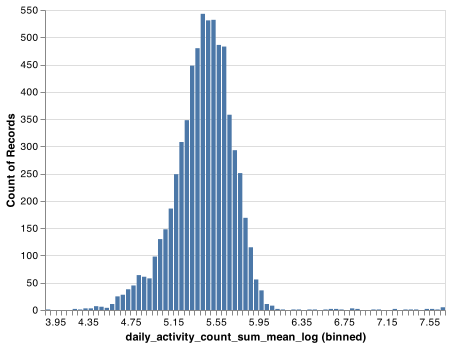

In [179]:
alt.Chart(person_active_counts_summary).mark_bar(clip=True).encode(
    alt.X(
        "daily_activity_count_sum_mean_log:Q",
        scale=alt.Scale(),
        bin=alt.Bin(maxbins=100),
    ),
    y="count()",
)

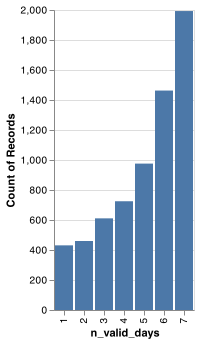

In [180]:
alt.Chart(person_active_counts_summary).mark_bar().encode(
    alt.X("n_valid_days:O"),
    y="count()",
)

In [181]:
# clear the crazy data
person_active_counts_summary = person_active_counts_summary.loc[
    person_active_counts_summary.daily_activity_count_sum_mean < 1500000, :
].copy()

In [182]:
cuts = 3
person_active_counts_summary["activity_tertile"] = pd.qcut(
    person_active_counts_summary.daily_activity_count_sum_mean,
    q=cuts,
    labels=range(1, cuts + 1),
)

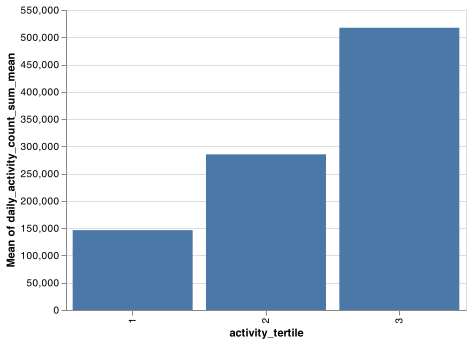

In [183]:
alt.Chart(person_active_counts_summary).mark_bar(clip=True).encode(
    alt.X("activity_tertile:O", scale=alt.Scale(), bin=False),
    y="mean(daily_activity_count_sum_mean)",
).properties(width=400)

## Examine the filters for valid people

In [184]:
d_people.loc[
    (d_people.zero_steps_with_intensity_sum > 10)
    | (d_people.too_many_steps_sum > 10)
    | (d_people.max_intensity_sum > 10),
    :,
].head(20)

,zero_steps_with_intensity_sum,too_many_steps_sum,max_intensity_sum,out_of_calibration_sum,out_of_calibration_last,unreliable_sum,unreliable_last,steps_filtered_500_sum,steps_filtered_300_sum,valid_day,PAXINTEN_sum
SEQN,,,,,,,,,,,
21316,0,0,858,10080,1,10080,1,0.0,0.0,7,3.402625e+07
21901,0,0,14,0,0,10080,1,0.0,0.0,6,6.965657e+05
22055,0,0,10080,10080,1,10080,1,0.0,0.0,7,4.718448e+07
22194,0,0,326,0,0,10080,1,0.0,0.0,0,1.561162e+06
22577,0,0,596,0,0,10080,1,0.0,0.0,5,3.085106e+06
22928,0,0,10080,10080,1,10080,1,0.0,0.0,7,4.718448e+07
23163,0,0,5338,0,0,10080,1,0.0,0.0,3,2.567916e+07
23772,0,0,10080,10080,1,10080,1,0.0,0.0,7,4.718448e+07
23953,0,0,7790,10080,1,10080,1,0.0,0.0,7,3.705471e+07


In [185]:
d_people.loc[
    (d_people.zero_steps_with_intensity_sum > 10)
    | (d_people.too_many_steps_sum > 10)
    | (d_people.max_intensity_sum > 10)
    | (d_people.out_of_calibration_last),
    :,
].head(20)

,zero_steps_with_intensity_sum,too_many_steps_sum,max_intensity_sum,out_of_calibration_sum,out_of_calibration_last,unreliable_sum,unreliable_last,steps_filtered_500_sum,steps_filtered_300_sum,valid_day,PAXINTEN_sum
SEQN,,,,,,,,,,,
21013,0,0,0,10080,1,0,0,0.0,0.0,5,1.733041e+05
21016,0,0,0,10080,1,0,0,0.0,0.0,5,2.343383e+05
21024,0,0,0,10080,1,0,0,0.0,0.0,0,1.503029e+05
21105,0,0,0,10080,1,0,0,0.0,0.0,1,4.047857e+04
21184,0,0,0,10080,1,0,0,0.0,0.0,2,9.412914e+04
21185,0,0,0,10080,1,0,0,0.0,0.0,7,1.304413e+05
21186,0,0,0,10080,1,0,0,0.0,0.0,4,2.472670e+05
21243,0,0,0,10080,1,0,0,0.0,0.0,4,3.139427e+05
21254,0,0,0,10080,1,0,0,0.0,0.0,0,1.008900e+04


In [186]:
d_people.loc[
    (d_people.zero_steps_with_intensity_sum > 10)
    | (d_people.too_many_steps_sum > 10)
    | (d_people.max_intensity_sum > 10)
    | (d_people.out_of_calibration_last)
    | (d_people.unreliable_last),
    :,
].head(20)

,zero_steps_with_intensity_sum,too_many_steps_sum,max_intensity_sum,out_of_calibration_sum,out_of_calibration_last,unreliable_sum,unreliable_last,steps_filtered_500_sum,steps_filtered_300_sum,valid_day,PAXINTEN_sum
SEQN,,,,,,,,,,,
21013,0,0,0,10080,1,0,0,0.0,0.0,5,1.733041e+05
21016,0,0,0,10080,1,0,0,0.0,0.0,5,2.343383e+05
21024,0,0,0,10080,1,0,0,0.0,0.0,0,1.503029e+05
21105,0,0,0,10080,1,0,0,0.0,0.0,1,4.047857e+04
21184,0,0,0,10080,1,0,0,0.0,0.0,2,9.412914e+04
21185,0,0,0,10080,1,0,0,0.0,0.0,7,1.304413e+05
21186,0,0,0,10080,1,0,0,0.0,0.0,4,2.472670e+05
21243,0,0,0,10080,1,0,0,0.0,0.0,4,3.139427e+05
21254,0,0,0,10080,1,0,0,0.0,0.0,0,1.008900e+04


In [187]:
d_unreliable = d_people.loc[
    (d_people.zero_steps_with_intensity_sum > 10)
    | (d_people.too_many_steps_sum > 10)
    | (d_people.max_intensity_sum > 10)
    | (d_people.out_of_calibration_last)
    | (d_people.unreliable_sum > 10)
    | (d_people.steps_filtered_500_sum > 200000),
    :,
]
d_unreliable.head(20)

,zero_steps_with_intensity_sum,too_many_steps_sum,max_intensity_sum,out_of_calibration_sum,out_of_calibration_last,unreliable_sum,unreliable_last,steps_filtered_500_sum,steps_filtered_300_sum,valid_day,PAXINTEN_sum
SEQN,,,,,,,,,,,
21013,0,0,0,10080,1,0,0,0.0,0.0,5,1.733041e+05
21016,0,0,0,10080,1,0,0,0.0,0.0,5,2.343383e+05
21024,0,0,0,10080,1,0,0,0.0,0.0,0,1.503029e+05
21105,0,0,0,10080,1,0,0,0.0,0.0,1,4.047857e+04
21184,0,0,0,10080,1,0,0,0.0,0.0,2,9.412914e+04
21185,0,0,0,10080,1,0,0,0.0,0.0,7,1.304413e+05
21186,0,0,0,10080,1,0,0,0.0,0.0,4,2.472670e+05
21243,0,0,0,10080,1,0,0,0.0,0.0,4,3.139427e+05
21254,0,0,0,10080,1,0,0,0.0,0.0,0,1.008900e+04


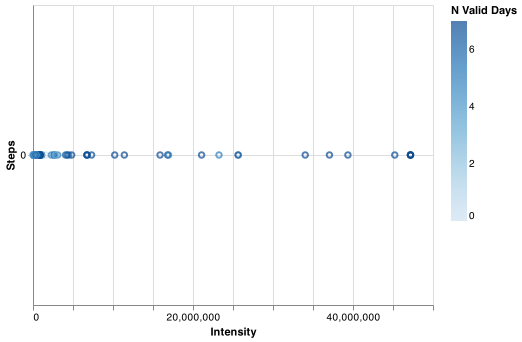

In [188]:
alt.Chart(d_unreliable).mark_point().encode(
    alt.X("PAXINTEN_sum", title="Intensity"),
    alt.Y("steps_filtered_500_sum", title="Steps"),
    alt.Color("valid_day", title="N Valid Days"),
)

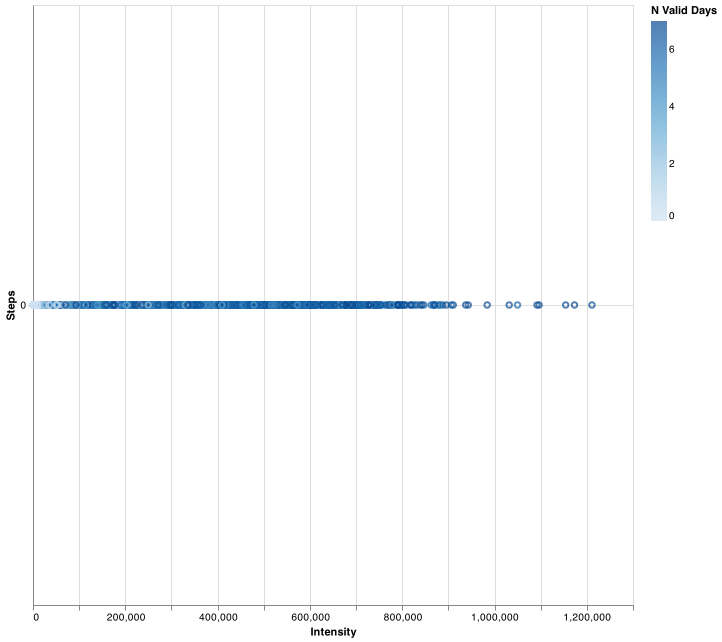

In [189]:
alt.Chart(d_reliable).mark_point().encode(
    alt.X("PAXINTEN_sum", title="Intensity"),
    alt.Y("steps_filtered_500_sum", title="Steps"),
    alt.Color("valid_day", title="N Valid Days"),
).properties(width=600, height=600)

# Correlation of steps and intensity

In [190]:
results = smf.ols("steps_filtered_500_sum ~ PAXINTEN_sum + 0", data=d_reliable).fit()
results.summary()

~/.pyenv/versions/3.10.4/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1754: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
~/.pyenv/versions/3.10.4/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1841: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
~/.pyenv/versions/3.10.4/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:940: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
~/.pyenv/versions/3.10.4/lib/python3.10/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     steps_filtered_500_sum   R-squared (uncentered):                     nan
Model:                                OLS   Adj. R-squared (uncentered):                nan
Method:                     Least Squares   F-statistic:                                nan
Date:                    Thu, 23 Feb 2023   Prob (F-statistic):                         nan
Time:                            14:14:00   Log-Likelihood:                             inf
No. Observations:                    6807   AIC:                                       -inf
Df Residuals:                        6806   BIC:                                       -inf
Df Model:                               1                                                  
Covariance Type:                nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
PAXINTEN_sum          0          0        nan        nan           0           0
==============================================================================
Omnibus:                          nan   Durbin-Watson:                     nan
Prob(Omnibus):                    nan   Jarque-Bera (JB):                  nan
Skew:                             nan   Prob(JB):                          nan
Kurtosis:                         nan   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

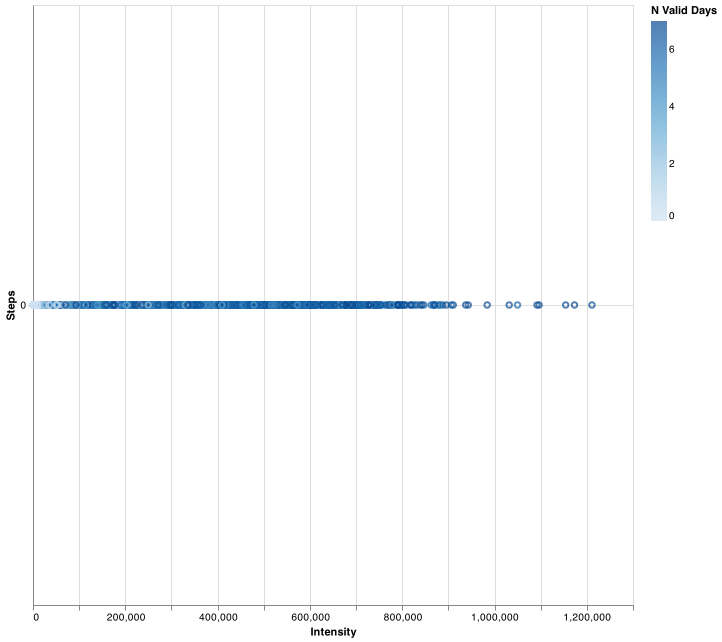

In [191]:
alt.Chart(d_reliable).mark_point().encode(
    alt.X("PAXINTEN_sum", title="Intensity"),
    alt.Y("steps_filtered_300_sum", title="Steps"),
    alt.Color("valid_day", title="N Valid Days"),
).properties(width=600, height=600)

In [192]:
results = smf.ols("steps_filtered_300_sum ~ PAXINTEN_sum + 0", data=d_reliable).fit()
results.summary()

~/.pyenv/versions/3.10.4/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1754: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss
~/.pyenv/versions/3.10.4/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1841: RuntimeWarning: invalid value encountered in double_scalars
  return self.mse_model/self.mse_resid
~/.pyenv/versions/3.10.4/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:940: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
~/.pyenv/versions/3.10.4/lib/python3.10/site-packages/statsmodels/stats/stattools.py:50: RuntimeWarning: invalid value encountered in double_scalars
  dw = np.sum(diff_resids**2, axis=axis) / np.sum(resids**2, axis=axis)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     steps_filtered_300_sum   R-squared (uncentered):                     nan
Model:                                OLS   Adj. R-squared (uncentered):                nan
Method:                     Least Squares   F-statistic:                                nan
Date:                    Thu, 23 Feb 2023   Prob (F-statistic):                         nan
Time:                            14:14:02   Log-Likelihood:                             inf
No. Observations:                    6807   AIC:                                       -inf
Df Residuals:                        6806   BIC:                                       -inf
Df Model:                               1                                                  
Covariance Type:                nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
PAXINTEN_sum          0          0        nan        nan           0           0
==============================================================================
Omnibus:                          nan   Durbin-Watson:                     nan
Prob(Omnibus):                    nan   Jarque-Bera (JB):                  nan
Skew:                             nan   Prob(JB):                          nan
Kurtosis:                         nan   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

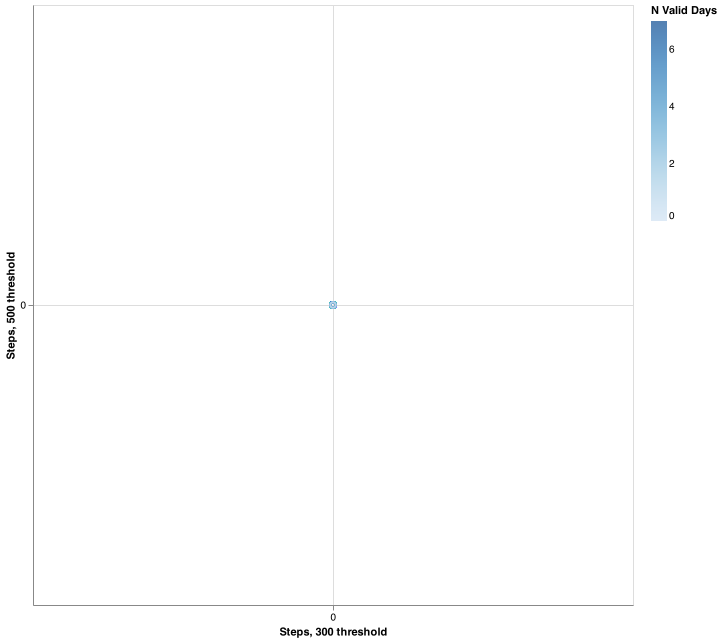

In [193]:
alt.Chart(d_reliable).mark_point().encode(
    alt.X("steps_filtered_300_sum", title="Steps, 300 threshold"),
    alt.Y("steps_filtered_500_sum", title="Steps, 500 threshold"),
    alt.Color("valid_day", title="N Valid Days"),
).properties(width=600, height=600)